# Movie Studio Data Analysis — Data Understanding

This notebook covers the **Business Understanding** and **Data Understanding**
phases of the CRISP-DM framework.

## Business Context

The company plans to launch a new movie studio but lacks historical experience
in film production. To reduce financial risk, historical movie data is analyzed
to identify characteristics associated with box office success.

Understanding the structure, coverage, and limitations of the available data
is a necessary first step before performing deeper analysis and making
business recommendations.

## Data Sources

Multiple datasets from different sources are used in this project:

- **IMDb (SQLite database)**: Provides movie metadata and audience ratings.
  Data is accessed using SQL queries on the `im.db` file.
- **Box Office Mojo**: Contains domestic and international box office revenue.
- **The Numbers**: Provides production budget and revenue information.
- **TMDB**: Includes popularity metrics and additional movie metadata.
- **Supplementary datasets**: Movie information and review data.

Because these datasets were collected independently, inconsistencies and missing
values are expected.

### Modules that will be used throughout the notebook

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from scipy import stats
import sqlite3
from pathlib import Path
import os
import re

# 1.Data Cleaning

## The purpose of this section is to load, inspect, and prepare the datasets used
## in the analysis, ensuring they are reliable and suitable for addressing the
## business problem.

In [50]:
# Define where raw data is stored
RAW_DATA = Path("../data/raw")

In [51]:
# Define where processed (cleaned) data will be saved
PROCESSED_DATA = Path("../data/processed")

# Create the processed folder if it does not already exist
PROCESSED_DATA.mkdir(exist_ok=True)
# output directory to dave our charts
out_dir= "../visuals/"

## Accessing IMDb Data Using SQL

IMDb data is stored in a SQLite database (`im.db`). SQL queries are used to
extract only the tables and fields relevant to this analysis.

The primary tables queried are:
- `movie_basics`: movie titles, release years, runtimes, and genres
- `movie_ratings`: average audience ratings and vote counts

In [52]:
# Specify the path to the IMDb SQLite database file
imdb_db_path = RAW_DATA / "im.db"

# Create a connection to the SQLite database
conn = sqlite3.connect(imdb_db_path)

## Extracting Core IMDb Tables

The following SQL queries extract core movie metadata and audience ratings.
Movies without a release year are excluded to ensure that time-based analysis
can be performed in later stages.

In [53]:
# Use an SQL query to list all tables inside the IMDb database
pd.read_sql(
    """
SELECT name
FROM sqlite_master
WHERE type = 'table';
""",
    conn,
)

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [54]:
# Use SQL to extract core movie information
# We only keep movies that have a release year
imdb_basics = pd.read_sql(
    """
SELECT
    movie_id,               -- unique movie ID
    primary_title,        -- movie title
    start_year,           -- year the movie was released
    runtime_minutes,      -- movie length
    genres                -- movie genres
FROM movie_basics
WHERE start_year IS NOT NULL;
""",
    conn,
)

In [55]:
# Use SQL to extract audience rating information
imdb_ratings = pd.read_sql(
    """
SELECT
    movie_id,               -- unique movie ID
    averagerating,       -- average IMDb rating
    numvotes             -- number of votes (popularity)
FROM movie_ratings;
""",
    conn,
)

# Close the database connection after extraction
conn.close()

## Initial Data Validation

After extracting the IMDb tables, basic validation is performed to confirm:

- The SQL queries executed successfully
- The number of records is reasonable
- Key variables such as release year and genre are present

This step helps identify potential data quality issues early in the workflow.

In [56]:
# Display the first few rows of each dataset
imdb_basics.head()
imdb_ratings.head()

# Check the number of rows and columns
imdb_basics.shape, imdb_ratings.shape

# Data types
imdb_basics.info()
imdb_ratings.info()

# Missing value proportions
imdb_basics.isna().mean()
imdb_ratings.isna().mean()

# Record time coverage and movie counts
imdb_year_min = imdb_basics["start_year"].min()
imdb_year_max = imdb_basics["start_year"].max()
imdb_movie_count = imdb_basics.shape[0]

imdb_year_min, imdb_year_max, imdb_movie_count

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   start_year       146144 non-null  int64  
 3   runtime_minutes  114405 non-null  float64
 4   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 5.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


(2010, 2115, 146144)

## Loading Additional Datasets

In addition to IMDb data, several datasets are provided as CSV files.
These datasets contain financial and supplementary movie information that
will be used in later stages of the analysis.

In [57]:
# Load Box Office Mojo data
bom = pd.read_csv(RAW_DATA / "bom.movie_gross.csv")

# Load The Numbers budget data
tn = pd.read_csv(RAW_DATA / "tn.movie_budgets.csv")

# Load TMDB movie data
tmdb = pd.read_csv(RAW_DATA / "tmdb.movies.csv")

# Load supplementary movie information
movie_info = pd.read_csv(RAW_DATA / "movie_info.csv")

# Load movie review data
movie_reviews = pd.read_csv(RAW_DATA / "movie_reviews.csv")

In [58]:
# Preview and structure checks
for name, df in {
    "Box Office Mojo": bom,
    "The Numbers": tn,
    "TMDB": tmdb,
    "Movie Info": movie_info,
    "Movie Reviews": movie_reviews,
}.items():
    print("\n---", name, "---")
    display(df.head())
    display(df.info())
    display(df.isna().mean())


--- Box Office Mojo ---


,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


None

title             0.000000
studio            0.001476
domestic_gross    0.008267
foreign_gross     0.398583
year              0.000000
dtype: float64


--- The Numbers ---


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


None

id                   0.0
release_date         0.0
movie                0.0
production_budget    0.0
domestic_gross       0.0
worldwide_gross      0.0
dtype: float64


--- TMDB ---


,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


None

Unnamed: 0           0.0
genre_ids            0.0
id                   0.0
original_language    0.0
original_title       0.0
popularity           0.0
release_date         0.0
title                0.0
vote_average         0.0
vote_count           0.0
dtype: float64


--- Movie Info ---


,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0    id           1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


None

 id             0.000000
synopsis        0.039744
rating          0.001923
genre           0.005128
director        0.127564
writer          0.287821
theater_date    0.230128
dvd_date        0.230128
currency        0.782051
box_office      0.782051
runtime         0.019231
studio          0.683333
dtype: float64


--- Movie Reviews ---


,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0    id         54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


None

 id           0.000000
review        0.102201
rating        0.248328
fresh         0.000000
critic        0.050007
top_critic    0.000000
publisher     0.005677
date          0.000000
dtype: float64

## Basic Data Standardization

To support future dataset integration, minimal standardization is applied:

- Movie titles are converted to lowercase and stripped of extra whitespace
- Year fields are converted to numeric values where applicable

At this stage, datasets are not merged. The objective is to prepare consistent
keys for downstream analysis.

In [59]:
# Define a helper function to clean movie titles
def clean_title(series):
    return (
        series.astype(str)  # ensure all values are strings
        .str.lower()  # convert to lowercase
        .str.strip()  # remove leading/trailing spaces
        .str.replace(r"\s+", " ", regex=True)  # remove extra spaces
    )


# Create cleaned title columns for future joining
imdb_basics["title_clean"] = clean_title(imdb_basics["primary_title"])
bom["title_clean"] = clean_title(bom["title"])
tn["title_clean"] = clean_title(tn["movie"])

# Convert year column to numeric format
imdb_basics["start_year"] = pd.to_numeric(imdb_basics["start_year"], errors="coerce")
bom["year"] = pd.to_numeric(bom["year"], errors="coerce")

## Saving Processed Datasets

Cleaned and standardized datasets are saved to the `data/processed` directory.
These processed files serve as inputs for subsequent analysis and visualization
steps.

In [60]:
# Save cleaned IMDb movie information
imdb_basics.to_csv(PROCESSED_DATA / "imdb_basics_clean.csv", index=False)

# Save cleaned IMDb ratings data
imdb_ratings.to_csv(PROCESSED_DATA / "imdb_ratings_clean.csv", index=False)

# Save cleaned Box Office Mojo data
bom.to_csv(PROCESSED_DATA / "bom_clean.csv", index=False)

# Save cleaned budget data
tn.to_csv(PROCESSED_DATA / "tn_budgets_clean.csv", index=False)

## High-Level Data Overview

A simple visualization is created to understand the distribution of movie
releases over time. This provides a general sense of dataset coverage without
drawing business conclusions.

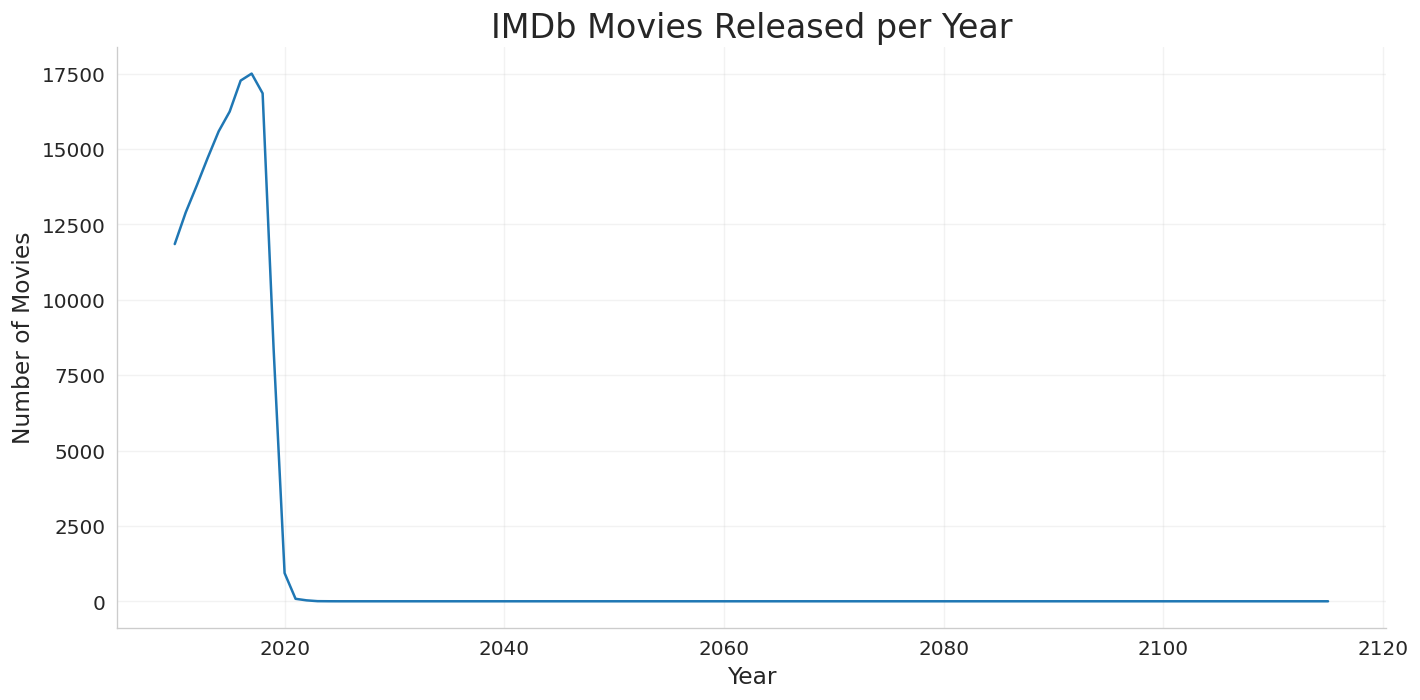

In [61]:
# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Count how many movies were released each year
year_counts = imdb_basics["start_year"].value_counts().sort_index()

# Create a simple line chart
plt.figure()
year_counts.plot(kind="line")
plt.title("IMDb Movies Released per Year")
plt.xlabel("Year")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.savefig(out_dir + "release_per_year.png")
plt.show()

## 

## Data Limitations and Assumptions

Several limitations should be considered when interpreting results from this data:

- Movie titles vary across datasets, making exact matching challenging
- IMDb genres are stored as multi-valued strings
- Revenue definitions differ across data sources
- Budget and foreign revenue data contain missing values
- Not all movies appear in every dataset

These limitations are documented to ensure transparency and responsible use
of the data in subsequent analysis stages.

## Load our processed datasets

In [62]:
bom = pd.read_csv("../data/processed/bom_clean.csv")
imdb_basics = pd.read_csv("../data/processed/imdb_basics_clean.csv")

imdb_ratings = pd.read_csv("../data/processed/imdb_ratings_clean.csv")
tn_budgets = pd.read_csv("../data/processed/tn_budgets_clean.csv")

# 2. Revenue Analysis; Domestis and Foreign Gross
## The purpose of this section is to make revenue analysis which will offer insight into expectations and matters that may arise in the venture of film production

In [63]:
# Convert gross columns to numeric, coercing errors to NaN
bom['domestic_gross'] = pd.to_numeric(bom['domestic_gross'], errors='coerce')
bom['foreign_gross'] = pd.to_numeric(bom['foreign_gross'], errors='coerce')

# Calculate totals
total_domestic = bom['domestic_gross'].sum()
total_foreign = bom['foreign_gross'].sum()

# Convert to millions for readability
total_domestic_million = round(total_domestic / 1_000_000, 2)
total_foreign_million = round(total_foreign / 1_000_000, 2)

# Print results
print(f"Total Domestic Gross: ${total_domestic_million} million")
print(f"Total Foreign Gross: ${total_foreign_million} million")


Total Domestic Gross: $96557.29 million
Total Foreign Gross: $152515.91 million


### 2.1 Calculating domestic_gross and foreign_gross mean

This will help us compare between the two has the highest gross amounts.

In [64]:
# Calculate mean for domestic and foreign gross

bom['domestic_gross'] = pd.to_numeric(bom['domestic_gross'], errors='coerce')
bom['foreign_gross'] = pd.to_numeric(bom['foreign_gross'], errors='coerce')

mean_domestic = bom['domestic_gross'].mean()
mean_foreign = bom['foreign_gross'].mean()

# Calculate the meaan difference between domestic and foreign gross
mean_difference = mean_foreign - mean_domestic

print(f"Mean Domestic Gross: ${mean_domestic:,.0f}")
print(f"Mean Foreign Gross: ${mean_foreign:,.0f}")
print(f"Mean Difference (Foreign - Domestic): ${mean_difference:,.0f}")


Mean Domestic Gross: $28,745,845
Mean Foreign Gross: $75,057,042
Mean Difference (Foreign - Domestic): $46,311,197


### 2.2 Figuring out revenue trends over the years

In [65]:
# Group revenue by year
yearly_revenue = bom.groupby('year')[['domestic_gross', 'foreign_gross']].mean().reset_index()

# Convert to millions and round for readability
yearly_revenue['domestic_gross'] = (yearly_revenue['domestic_gross'] / 1_000_000).round(2)
yearly_revenue['foreign_gross'] = (yearly_revenue['foreign_gross'] / 1_000_000).round(2)
yearly_revenue


,year,domestic_gross,foreign_gross
0,2010,31.45,45.78
1,2011,25.35,53.48
2,2012,27.68,68.15
3,2013,31.28,81.04
4,2014,26.44,71.31
5,2015,24.61,80.87
6,2016,25.99,98.05
7,2017,34.17,113.28
8,2018,36.01,101.60


## 2.3 Studio Performance Analysis

We aim to identify which studio generates the highest total revenue separately for domestic and foreign markets.

This analysis helps us understand:

-Which studios are dominating domestic markets.

-Which studios are performing best in international markets.

-The comparison between domestic and foreign earnings by studio.

## 2.4 Studio with Highest Domestic Gross

In [66]:
# Studio with Highest Domestic Gross

bom['domestic_gross'] = pd.to_numeric(bom['domestic_gross'], errors='coerce')

# Group by studio: sum gross and count movies
studio_domestic_stats = bom.groupby('studio').agg(
    total_domestic=('domestic_gross', 'sum'),
    num_movies=('domestic_gross', 'count')
)

# Find studio with highest domestic gross
top_domestic_studio = studio_domestic_stats['total_domestic'].idxmax()
top_domestic_amount = studio_domestic_stats['total_domestic'].max()
top_domestic_movies = studio_domestic_stats.loc[top_domestic_studio, 'num_movies']

print(f"Studio with Highest Domestic Gross: {top_domestic_studio}")
print(f"Total Domestic Gross: ${top_domestic_amount:,.0f}")
print(f"Number of Movies: {top_domestic_movies}\n")



Studio with Highest Domestic Gross: BV
Total Domestic Gross: $18,419,029,199
Number of Movies: 106



## 2.5 Studio with Highest Foreign Gross

In [67]:
# Studio with Highest Foreign Gross

bom['foreign_gross'] = pd.to_numeric(bom['foreign_gross'], errors='coerce')

# Group by studio: sum gross and count movies
studio_foreign_stats = bom.groupby('studio').agg(
    total_foreign=('foreign_gross', 'sum'),
    num_movies=('foreign_gross', 'count')
)

# Find studio with highest foreign gross
top_foreign_studio = studio_foreign_stats['total_foreign'].idxmax()
top_foreign_amount = studio_foreign_stats['total_foreign'].max()
top_foreign_movies = studio_foreign_stats.loc[top_foreign_studio, 'num_movies']

print(f"Studio with Highest Foreign Gross: {top_foreign_studio}")
print(f"Total Foreign Gross: ${top_foreign_amount:,.0f}")
print(f"Number of Movies: {top_foreign_movies}")


Studio with Highest Foreign Gross: BV
Total Foreign Gross: $25,793,852,199
Number of Movies: 102


## 2.6 Top Studios by Domestic and Foreign Gross Each Year

In [68]:
# Calculate total gross for each movie
bom['domestic_gross'] = pd.to_numeric(bom['domestic_gross'], errors='coerce')
bom['foreign_gross'] = pd.to_numeric(bom['foreign_gross'], errors='coerce')

# Group by year and studio, summing gross
studio_year_revenue = bom.groupby(['year', 'studio'])[['domestic_gross', 'foreign_gross']].sum().reset_index()

# Convert to millions and round for readability
studio_year_revenue['domestic_gross'] = (studio_year_revenue['domestic_gross'] / 1_000_000).round(2)
studio_year_revenue['foreign_gross'] = (studio_year_revenue['foreign_gross'] / 1_000_000).round(2)

# Find studio with highest domestic gross per year
top_domestic_studios = studio_year_revenue.loc[studio_year_revenue.groupby('year')['domestic_gross'].idxmax()]

# Find studio with highest foreign gross per year
top_foreign_studios = studio_year_revenue.loc[studio_year_revenue.groupby('year')['foreign_gross'].idxmax()]

# Preview results
print("Top Domestic Studios by Year:")
print(top_domestic_studios)

print("\nTop Foreign Studios by Year:")
print(top_foreign_studios)

Top Domestic Studios by Year:
     year studio  domestic_gross  foreign_gross
6    2010     BV         1519.13        2652.04
150  2011     WB         1575.20        2275.23
163  2012     BV         1575.90        2026.20
242  2013     BV         1816.40        3233.20
347  2014    Fox         1814.40        3627.00
412  2015     BV         2495.70        2550.11
499  2016     BV         2871.00        4393.30
594  2017     BV         2378.20        3946.60
671  2018     BV         3045.60        2621.80

Top Foreign Studios by Year:
     year studio  domestic_gross  foreign_gross
6    2010     BV         1519.13        2652.04
150  2011     WB         1575.20        2275.23
221  2012   Sony         1435.60        2477.90
242  2013     BV         1816.40        3233.20
347  2014    Fox         1814.40        3627.00
412  2015     BV         2495.70        2550.11
499  2016     BV         2871.00        4393.30
594  2017     BV         2378.20        3946.60
738  2018     WB         172

## 2.7 Total Movies Produced by Each Studio

In [69]:
# Count total number of movies per studio
total_movies_per_studio = bom.groupby('studio')['title_clean'].count().reset_index()

# Rename column for clarity
total_movies_per_studio.rename(columns={'title_clean': 'total_movies'}, inplace=True)

# Preview results
total_movies_per_studio.sort_values(by='total_movies', ascending=False)

,studio,total_movies
113,IFC,166
238,Uni.,147
246,WB,140
148,Magn.,136
93,Fox,136
...,...,...
20,App.,1
22,Argo.,1
255,Zee,1
250,WOW,1


## 2.8  Findings Summary

### 1. Foreign revenue dominates: Average foreign gross per movie is consistently higher than domestic.

### 2. Domestic revenue is stable: Averages hover around $25–36M, showing limited growth.

### 3. Foreign revenue grows over time: From $45.78M in 2010 to $101.6M in 2018.

### 4. Gap widens: Later years show foreign earnings ≈ 3× domestic, highlighting global market potential.

### 5. BV Studio is the most consistent performer in both domestic and foreign markets

### 6. IFC Studio has produced the highest number of movies overall, with a total of 166 films.


## 2.9 Bar Chart: Total Domestic vs. Total Foreign Gros

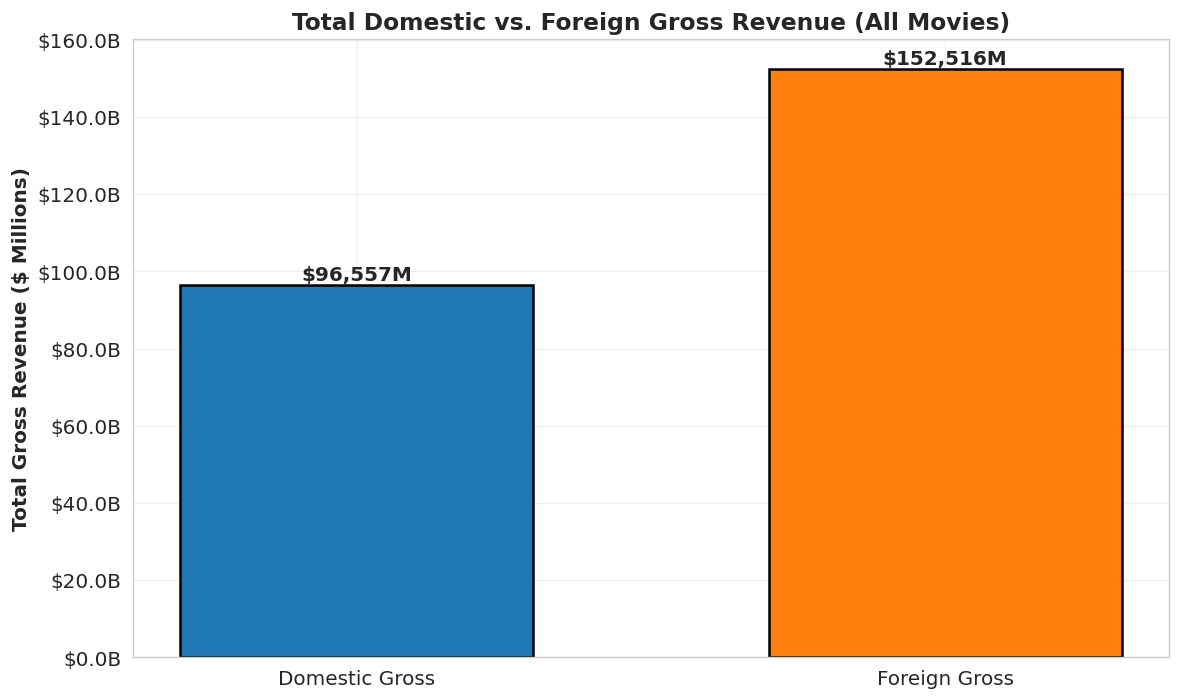

In [70]:
# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Create bar chart comparing total domestic vs foreign gross
fig, ax = plt.subplots(figsize=(10, 6))

categories = ['Domestic Gross', 'Foreign Gross']
totals = [total_domestic_million, total_foreign_million]
colors = ['#1f77b4', '#ff7f0e']

bars = ax.bar(categories, totals, color=colors, width=0.6, edgecolor='black', linewidth=1.5)

# Add value labels on top of bars
for bar, total in zip(bars, totals):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'${total:,.0f}M',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# Customize the plot
ax.set_ylabel('Total Gross Revenue ($ Millions)', fontsize=12, fontweight='bold')
ax.set_title('Total Domestic vs. Foreign Gross Revenue (All Movies)', fontsize=14, fontweight='bold')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.1f}B'))

# Add grid for better readability
ax.grid(True, alpha=0.3, axis='y')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig(out_dir + "dom_vs_for_gross.png")
plt.show()

### Key insights from the visualization:

### Domestic Gross: $96.6 billion (blue bar)
### Foreign Gross: $152.5 billion (orange bar)
### Foreign dominates with approximately 1.6x more revenue than domestic markets

## 2.10 Line Chart: Domestic vs. Foreign Revenue Over Time

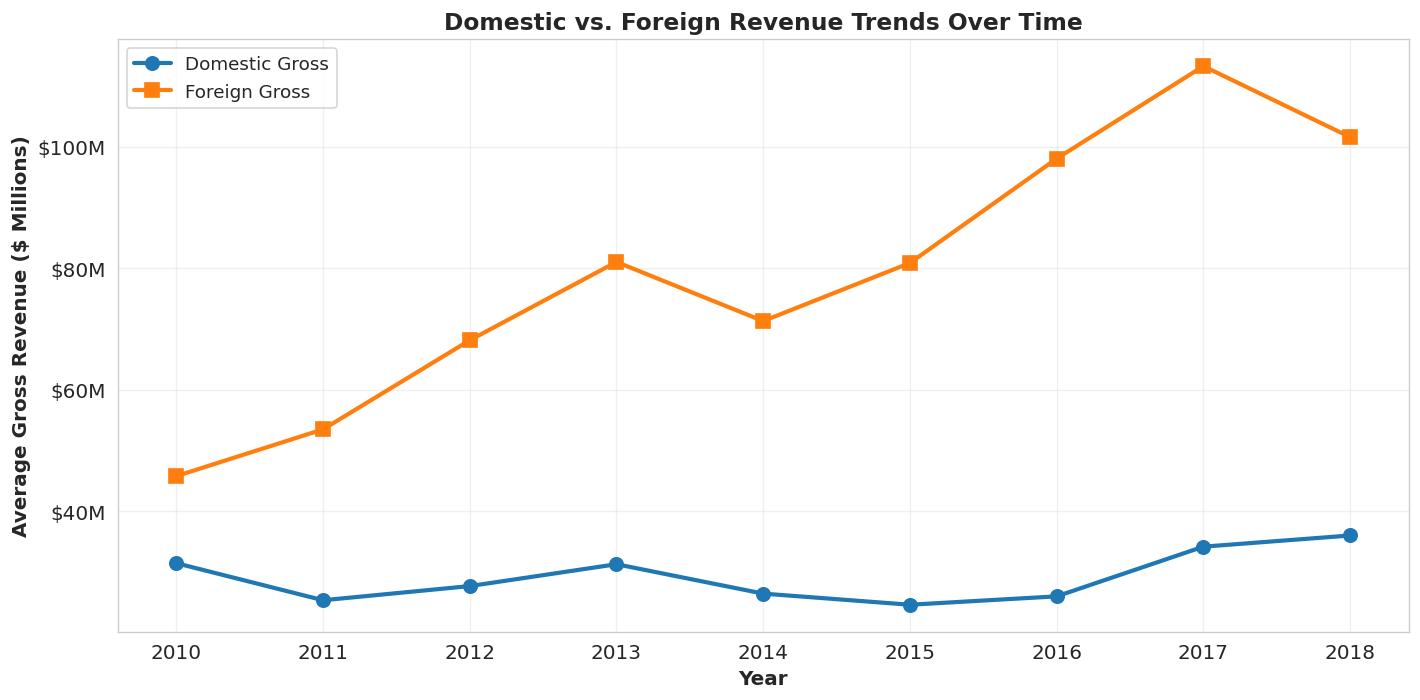

In [71]:
# Create yearly_revenue if not already defined
if 'yearly_revenue' not in locals():
    yearly_revenue = bom.groupby('year')[['domestic_gross', 'foreign_gross']].mean().reset_index()
    yearly_revenue['domestic_gross'] = (yearly_revenue['domestic_gross'] / 1_000_000).round(2)
    yearly_revenue['foreign_gross'] = (yearly_revenue['foreign_gross'] / 1_000_000).round(2)

# Create line chart for domestic vs foreign revenue trends
fig, ax = plt.subplots(figsize=(12, 6))

# Plot domestic and foreign revenue trends
ax.plot(yearly_revenue['year'], yearly_revenue['domestic_gross'], 
        marker='o', linewidth=2.5, label='Domestic Gross', color='#1f77b4', markersize=8)
ax.plot(yearly_revenue['year'], yearly_revenue['foreign_gross'], 
        marker='s', linewidth=2.5, label='Foreign Gross', color='#ff7f0e', markersize=8)

# Customize the plot
ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Gross Revenue ($ Millions)', fontsize=12, fontweight='bold')
ax.set_title('Domestic vs. Foreign Revenue Trends Over Time', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='upper left')
ax.grid(True, alpha=0.3)

# Format y-axis as currency
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.0f}M'))

plt.tight_layout()
plt.savefig(out_dir + "rev_trends_over_time.png")
plt.show()

### Key insights from the chart:

### Domestic revenue (blue line) remains relatively stable at $25-36M throughout the period
### Foreign revenue (orange line) shows significant growth, rising from ~$46M in 2010 to peak at ~$107M in 2017
### Widening gap: The gap between foreign and domestic revenue increases dramatically over time, with foreign eventually reaching 3x the domestic revenue
### Growth pattern: Foreign revenue demonstrates consistent upward momentum, particularly accelerating from 2015 onwards

## 2.11 Grouped Bar Chart: Top Studios - Domestic vs. Foreign Comparison

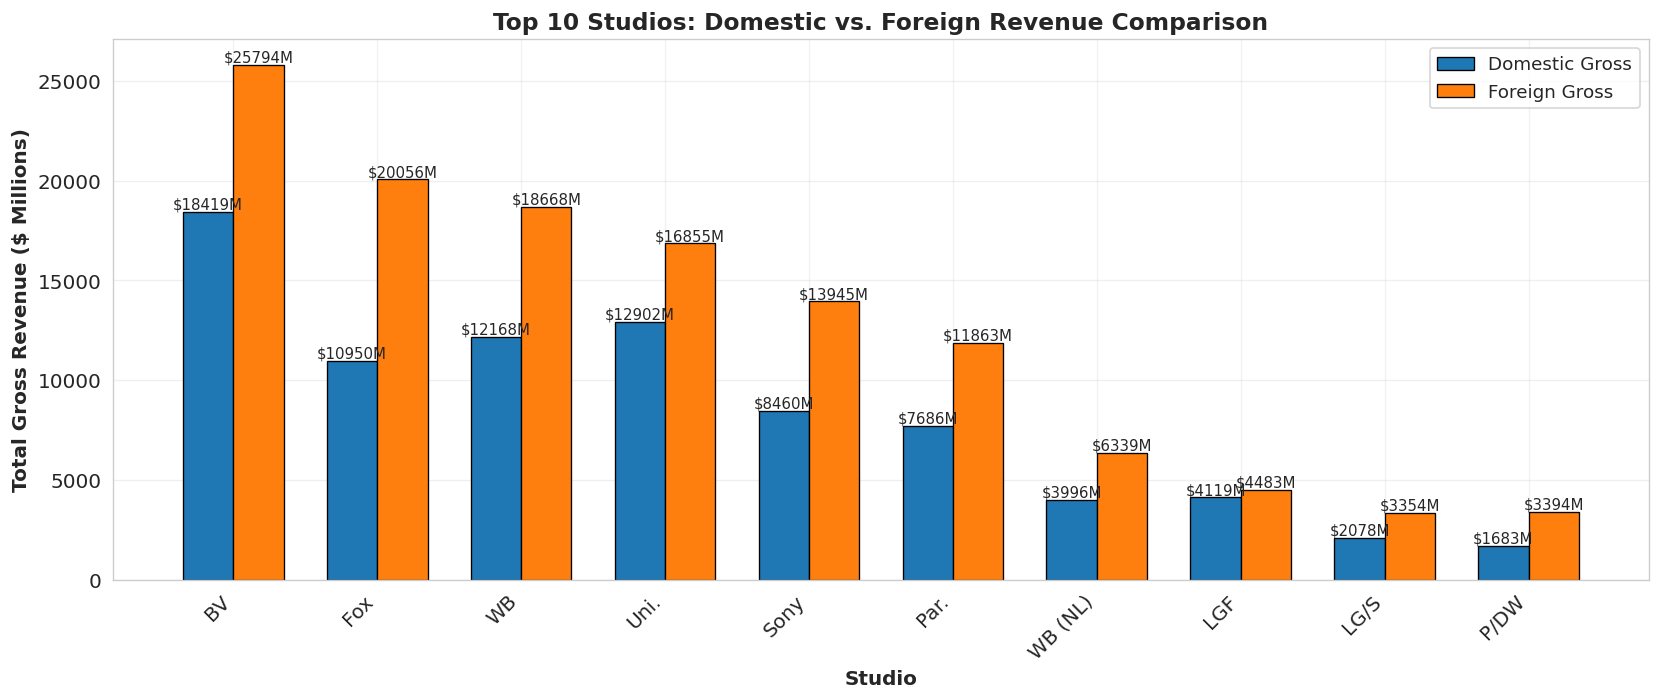

Top 10 Studios - Revenue Breakdown:
 studio  domestic_gross  foreign_gross  total_gross
     BV        18419.03       25793.85     44212.88
    Fox        10949.50       20055.87     31005.37
     WB        12168.05       18667.90     30835.95
   Uni.        12902.39       16854.77     29757.16
   Sony         8459.68       13945.35     22405.03
   Par.         7685.87       11863.38     19549.25
WB (NL)         3995.70        6339.00     10334.70
    LGF         4118.96        4482.62      8601.58
   LG/S         2078.20        3353.72      5431.92
   P/DW         1682.90        3393.60      5076.50


In [72]:
# Get top studios by total revenue (domestic + foreign)
studio_revenue = bom.groupby('studio').agg({
    'domestic_gross': 'sum',
    'foreign_gross': 'sum'
}).reset_index()

# Convert to millions
studio_revenue['domestic_gross'] = (studio_revenue['domestic_gross'] / 1_000_000).round(2)
studio_revenue['foreign_gross'] = (studio_revenue['foreign_gross'] / 1_000_000).round(2)
studio_revenue['total_gross'] = studio_revenue['domestic_gross'] + studio_revenue['foreign_gross']

# Get top 10 studios by total revenue
top_10_studios = studio_revenue.nlargest(10, 'total_gross')

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(14, 6))

x = range(len(top_10_studios))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], top_10_studios['domestic_gross'], 
               width, label='Domestic Gross', color='#1f77b4', edgecolor='black', linewidth=0.8)
bars2 = ax.bar([i + width/2 for i in x], top_10_studios['foreign_gross'], 
               width, label='Foreign Gross', color='#ff7f0e', edgecolor='black', linewidth=0.8)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'${height:.0f}M',
                ha='center', va='bottom', fontsize=9)

# Customize the plot
ax.set_xlabel('Studio', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Gross Revenue ($ Millions)', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Studios: Domestic vs. Foreign Revenue Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(top_10_studios['studio'], rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig(out_dir + "top10_studio_rev_comparison.png")
plt.show()

# Display the data
print("Top 10 Studios - Revenue Breakdown:")
print(top_10_studios[['studio', 'domestic_gross', 'foreign_gross', 'total_gross']].to_string(index=False))

# 3. IMDb Exploratory Data Analysis

## Initial Data Overview

In [73]:
imdb_ratings.head()
imdb_ratings.info()
imdb_ratings.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


,averagerating,numvotes
count,73856.000000,7.385600e+04
mean,6.332729,3.523662e+03
std,1.474978,3.029402e+04
min,1.000000,5.000000e+00
25%,5.500000,1.400000e+01
50%,6.500000,4.900000e+01
75%,7.400000,2.820000e+02
max,10.000000,1.841066e+06


In [74]:
imdb_basics.info()
imdb_basics.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146143 non-null  object 
 2   start_year       146144 non-null  int64  
 3   runtime_minutes  114405 non-null  float64
 4   genres           140736 non-null  object 
 5   title_clean      146144 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


,movie_id,primary_title,start_year,runtime_minutes,genres,title_clean
0,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",sunghursh
1,tt0066787,One Day Before the Rainy Season,2019,114.0,"Biography,Drama",one day before the rainy season
2,tt0069049,The Other Side of the Wind,2018,122.0,Drama,the other side of the wind
3,tt0069204,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",sabse bada sukh
4,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy",the wandering soap opera


## 3.1 Merge data sets

In [75]:
# Merge datasets on 'movie_id'
df = pd.merge(imdb_basics, imdb_ratings,on='movie_id')
df.head()

,movie_id,primary_title,start_year,runtime_minutes,genres,title_clean,averagerating,numvotes
0,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",sunghursh,7.0,77
1,tt0066787,One Day Before the Rainy Season,2019,114.0,"Biography,Drama",one day before the rainy season,7.2,43
2,tt0069049,The Other Side of the Wind,2018,122.0,Drama,the other side of the wind,6.9,4517
3,tt0069204,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",sabse bada sukh,6.1,13
4,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy",the wandering soap opera,6.5,119


## Columns check

In [76]:
print(df.columns.tolist())
# Clean column names
df = df.rename(columns={
    'numvotes': 'num_votes',
    'averagerating': 'average_ratings',
    'start_year': 'release_year'
     
})
df

['movie_id', 'primary_title', 'start_year', 'runtime_minutes', 'genres', 'title_clean', 'averagerating', 'numvotes']


,movie_id,primary_title,release_year,runtime_minutes,genres,title_clean,average_ratings,num_votes
0,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",sunghursh,7.0,77
1,tt0066787,One Day Before the Rainy Season,2019,114.0,"Biography,Drama",one day before the rainy season,7.2,43
2,tt0069049,The Other Side of the Wind,2018,122.0,Drama,the other side of the wind,6.9,4517
3,tt0069204,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",sabse bada sukh,6.1,13
4,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy",the wandering soap opera,6.5,119
...,...,...,...,...,...,...,...,...
73851,tt9913084,Diabolik sono io,2019,75.0,Documentary,diabolik sono io,6.2,6
73852,tt9914286,Sokagin Çocuklari,2019,98.0,"Drama,Family",sokagin çocuklari,8.7,136
73853,tt9914642,Albatross,2017,NaN,Documentary,albatross,8.5,8
73854,tt9914942,La vida sense la Sara Amat,2019,NaN,NaN,la vida sense la sara amat,6.6,5


## 3.2 Univariate analysis
### 3.2.1 Ratings Distribution
To understand audience reception, we examine the distribution of movie average ratings using a histogram and box plot.

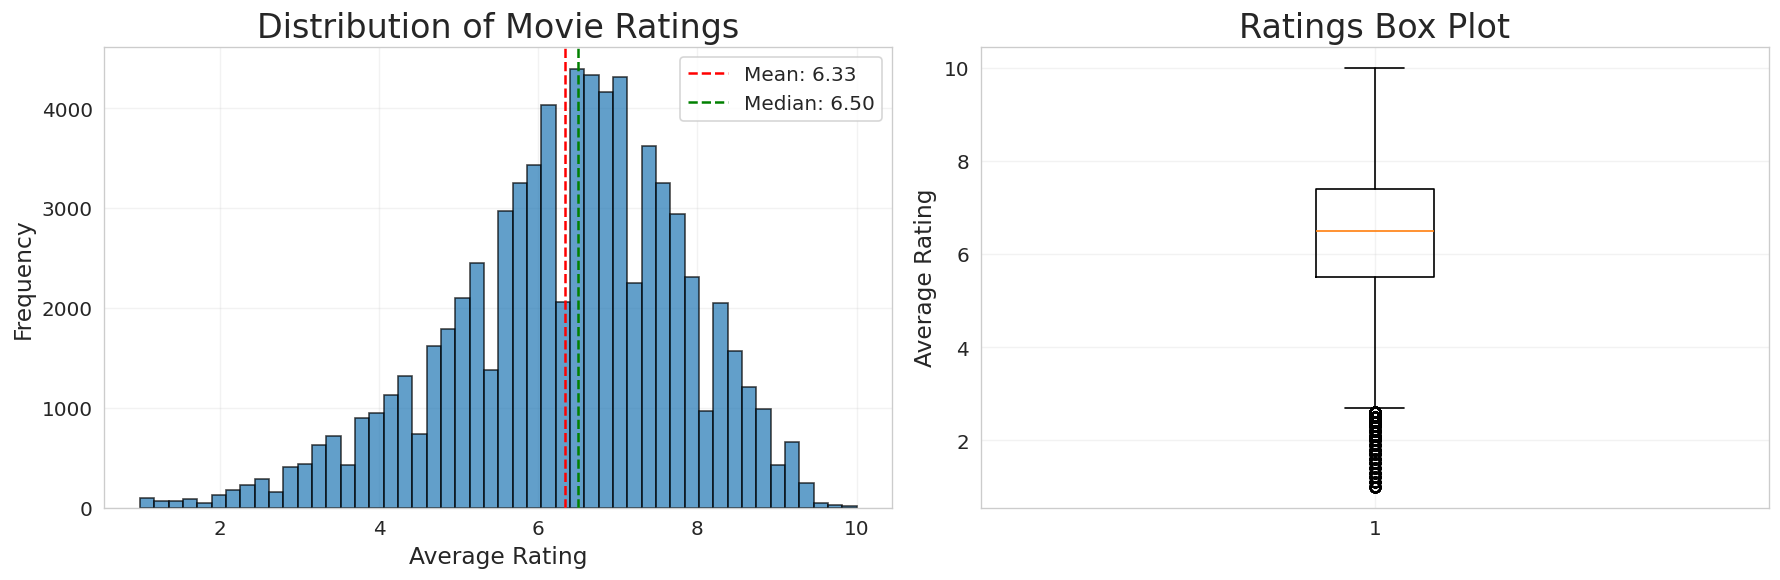

Rating Statistics:
Mean: 6.33
Median: 6.50
Std Dev: 1.47
Skewness: -0.55


In [77]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

# Histogram
axes[0].hist(df['average_ratings'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(df['average_ratings'].mean(), color='red', linestyle='--', label=f'Mean: {df["average_ratings"].mean():.2f}')
axes[0].axvline(df['average_ratings'].median(), color='green', linestyle='--', label=f'Median: {df["average_ratings"].median():.2f}')
axes[0].set_xlabel('Average Rating')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Movie Ratings')
axes[0].legend()

# Box plot
axes[1].boxplot(df['average_ratings'].dropna(), vert=True)
axes[1].set_ylabel('Average Rating')
axes[1].set_title('Ratings Box Plot')

plt.tight_layout()
plt.savefig(out_dir + "ratings_distribution.png")
plt.show()

print(f"Rating Statistics:")
print(f"Mean: {df['average_ratings'].mean():.2f}")
print(f"Median: {df['average_ratings'].median():.2f}")
print(f"Std Dev: {df['average_ratings'].std():.2f}")
print(f"Skewness: {df['average_ratings'].skew():.2f}")

### The distribution shows that most movies cluster around the mean rating.
### The similarity between the mean and median suggests limited skewness, while the box plot highlights the presence of potential outliers.

### 3.2.2 Votes Distribution
To understand audience engagement, we examine the distribution of the number of votes each movie received. 
Because vote counts often vary widely and can be highly skewed, we visualize both the original scale and a log-transformed scale for better interpretability.

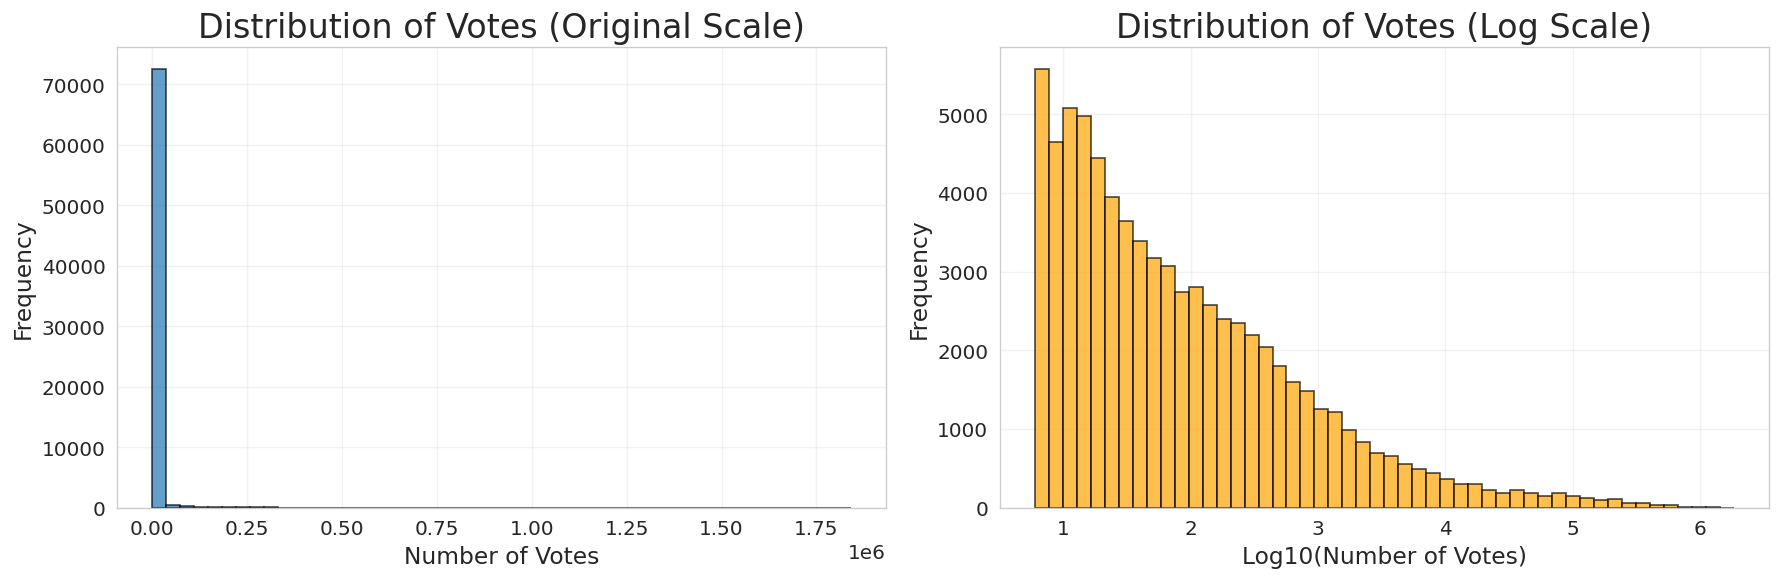

Vote Statistics:
Mean: 3,524
Median: 49
Max: 1,841,066
75th percentile: 282


In [78]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Original scale
axes[0].hist(df['num_votes'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Votes')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Votes (Original Scale)')

# Log scale for better visibility
axes[1].hist(np.log10(df['num_votes'].dropna() + 1), bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Log10(Number of Votes)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Votes (Log Scale)')

plt.tight_layout()
plt.savefig(out_dir + "votes_distribution.png")
plt.show()

print(f"Vote Statistics:")
print(f"Mean: {df['num_votes'].mean():,.0f}")
print(f"Median: {df['num_votes'].median():,.0f}")
print(f"Max: {df['num_votes'].max():,.0f}")
print(f"75th percentile: {df['num_votes'].quantile(0.75):,.0f}")

### The original-scale histogram shows a highly right-skewed distribution, where most movies receive relatively few votes, while a small number of movies receive extremely high vote counts.

### After applying a log transformation, the distribution becomes more balanced and easier to interpret. This confirms that vote counts are heavily concentrated among a small subset of highly popular films, while the majority receive moderate to low engagement.

### The large gap between the mean and median further supports the presence of positive skewness, driven by high-vote outliers.

### 3.2.3 Genre Analysis
To understand content distribution within the dataset, we extract individual genres from the multi-label genre column and analyze their frequency. This allows us to identify the most dominant genres and understand overall production trends.

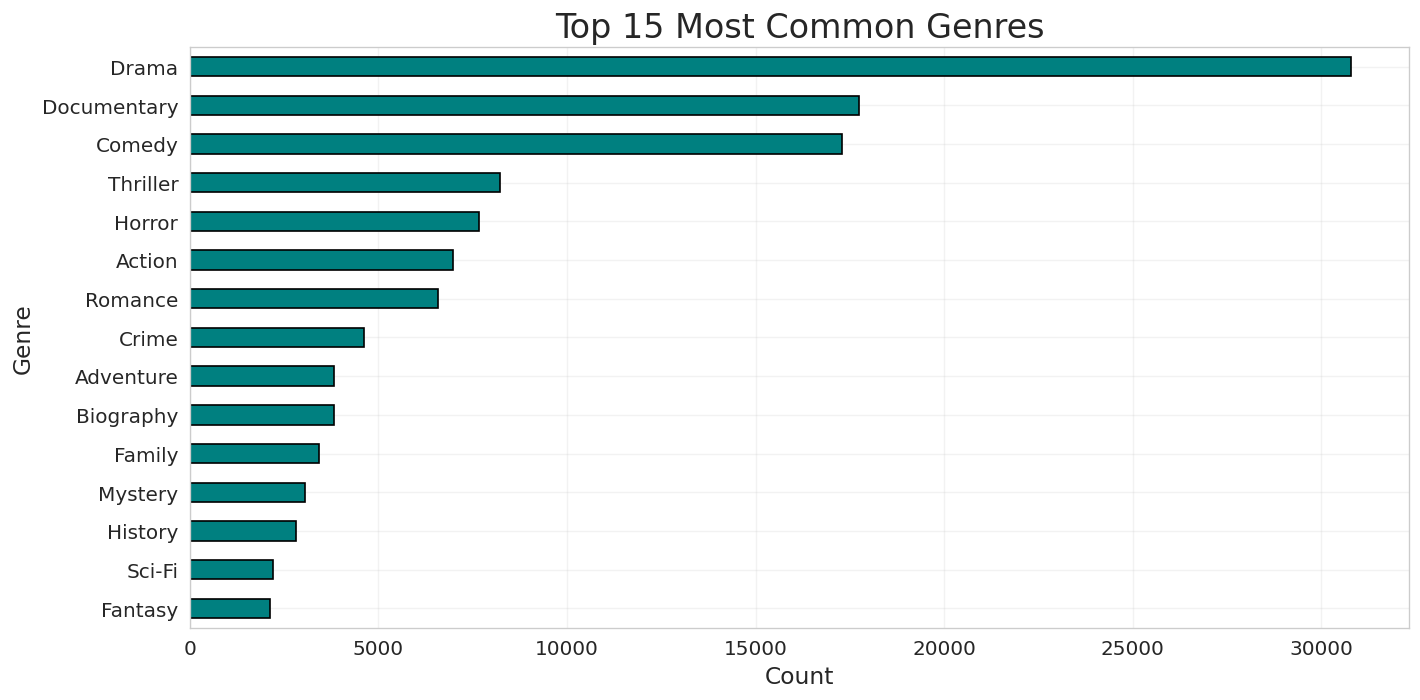

Total unique genres: 26


In [79]:
# Extract and count individual genres
all_genres = []
for genres in df['genres'].dropna():
    if isinstance(genres, str):
        all_genres.extend([g.strip() for g in genres.split(',')])

genre_counts = pd.Series(all_genres).value_counts().head(15)

plt.figure(figsize=(12, 6))
genre_counts.plot(kind='barh', color='teal', edgecolor='black')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.title('Top 15 Most Common Genres')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(out_dir + "genre_analysis.png")
plt.show()

print(f"Total unique genres: {len(pd.Series(all_genres).unique())}")

### The bar chart shows the top 15 most common genres in the dataset. A small number of genres dominate production, while many others appear less frequently.

### This concentration suggests that the industry prioritizes certain commercially viable or popular genres. The total number of unique genres also indicates diversity in content, though production volume is not evenly distributed across them.

# 3.3 Bivariate Analysis
### 3.3.1 Ratings by Genre
To evaluate which genres perform best in terms of audience reception, we calculate summary statistics for each genre, including mean rating, median rating, standard deviation, movie count, and average number of votes.

To ensure reliability and avoid distortions from small sample sizes, we filter for genres with at least 20 movies before ranking them by average rating.

In [80]:
df['genre_list'] = df['genres'].str.split(', ')
df_exploded = df.explode('genre_list')

# Calculate genre statistics

genre_stats = df_exploded.groupby('genre_list').agg({
    'average_ratings': ['mean', 'median', 'std', 'count'],
    'num_votes': 'mean'
}).round(2)

genre_stats.columns = ['_'.join(col).strip() for col in genre_stats.columns.values]
genre_stats = genre_stats.sort_values('average_ratings_mean', ascending=False)

# Filter genres with at least 20 movies
genre_stats_filtered = genre_stats[genre_stats['average_ratings_count'] >= 20]

print("Top 15 Genres by Average Rating (min 20 movies):")
print(genre_stats_filtered.head(15))

Top 15 Genres by Average Rating (min 20 movies):
                              average_ratings_mean  average_ratings_median  \
genre_list                                                                   
Documentary,Family,Music                      7.69                    7.80   
Music                                         7.62                    8.00   
Documentary,Drama,War                         7.61                    7.40   
Action,Documentary,Drama                      7.60                    7.60   
Adventure,Documentary,Sport                   7.60                    7.60   
Adventure,Documentary,Family                  7.60                    7.60   
Documentary,Drama,Sport                       7.60                    7.50   
Biography,Documentary,Music                   7.57                    7.60   
Adventure,Documentary                         7.57                    7.60   
Action,Biography,Documentary                  7.56                    7.25   
Documentary,His

### The results show the top-performing genres based on average audience ratings, considering only genres with sufficient representation (at least 20 movies).

### By applying a minimum movie threshold, we reduce the impact of outliers and ensure the rankings reflect consistent performance rather than isolated high-rated films. 

### Genres at the top of the list demonstrate stronger overall audience reception, while differences between mean and median ratings may indicate the presence of outliers or rating variability within certain categories.

### Additionally, the average vote count provides insight into engagement levels, helping distinguish between highly rated niche genres and widely popular mainstream genres.


## 3.3.2 Average ratings across different genres chart.

To better understand genre dynamics, we compare the top 15 genres by average rating (with at least 20 movies) against the top 15 most frequently produced genres.

This allows us to examine whether the most common genres are also the highest rated, or if production volume differs from audience preference.

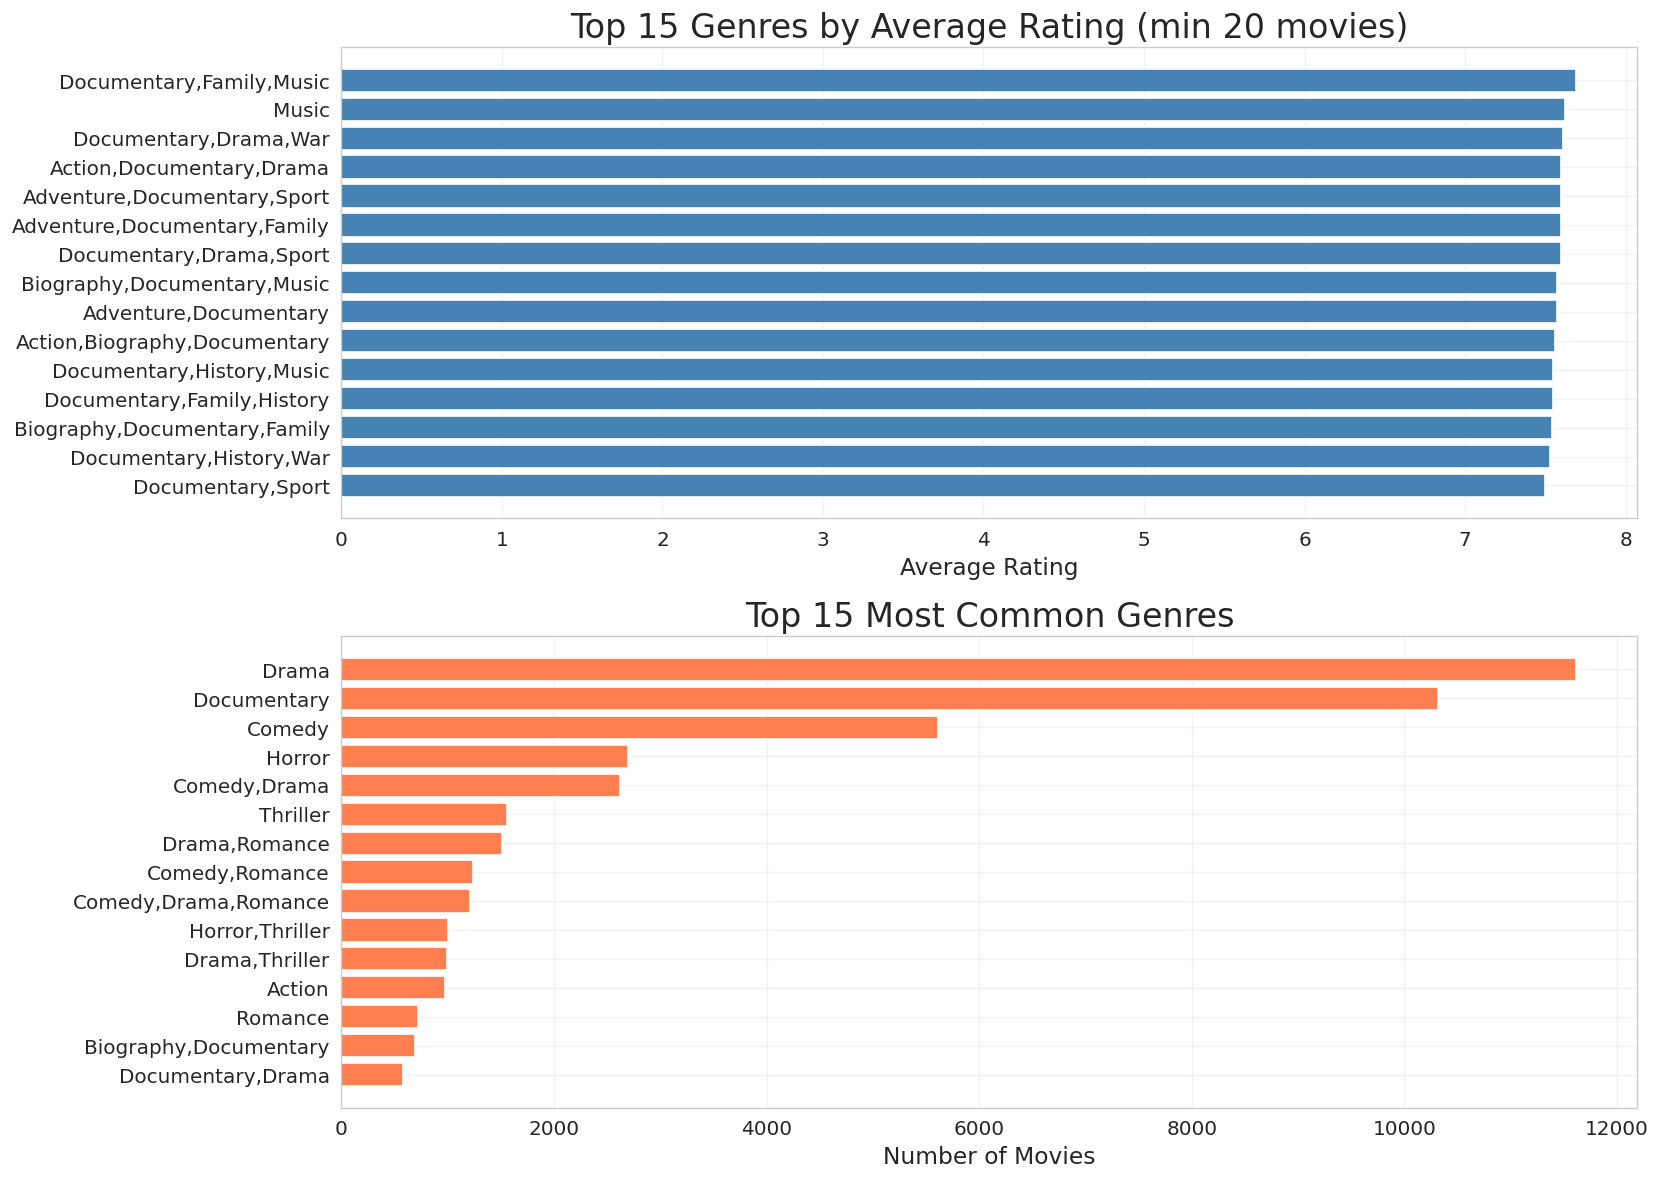

In [81]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Top genres by rating
top_15 = genre_stats_filtered.head(15)
axes[0].barh(range(len(top_15)), top_15['average_ratings_mean'], color='steelblue')
axes[0].set_yticks(range(len(top_15)))
axes[0].set_yticklabels(top_15.index)
axes[0].set_xlabel('Average Rating')
axes[0].set_title('Top 15 Genres by Average Rating (min 20 movies)')
axes[0].invert_yaxis()

# Genre count
top_genres_count = df_exploded['genre_list'].value_counts().head(15)
axes[1].barh(range(len(top_genres_count)), top_genres_count.values, color='coral')
axes[1].set_yticks(range(len(top_genres_count)))
axes[1].set_yticklabels(top_genres_count.index)
axes[1].set_xlabel('Number of Movies')
axes[1].set_title('Top 15 Most Common Genres')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig(out_dir + "avg_ratings_in_genres.png")
plt.show()

### The first chart highlights the top-rated genres, reflecting strong audience reception among sufficiently represented categories. The second chart shows the most frequently produced genres in the dataset.

### Comparing the two reveals that production volume does not always align with audience ratings. Some highly produced genres may not rank among the highest-rated, while certain top-rated genres are less frequently produced.

### This suggests that industry output may be driven by commercial familiarity or market trends rather than purely audience satisfaction. Identifying genres that combine both high ratings and high production volume could indicate strong, sustainable market segments.

## 3.4 Votes vs Ratings Relationship
To explore whether more popular movies tend to receive higher ratings, we analyze the relationship between the number of votes (a proxy for engagement) and average ratings.

Because vote counts are highly skewed, we apply a logarithmic transformation for better visualization and use both Pearson and Spearman correlations to assess linear and monotonic relationships.

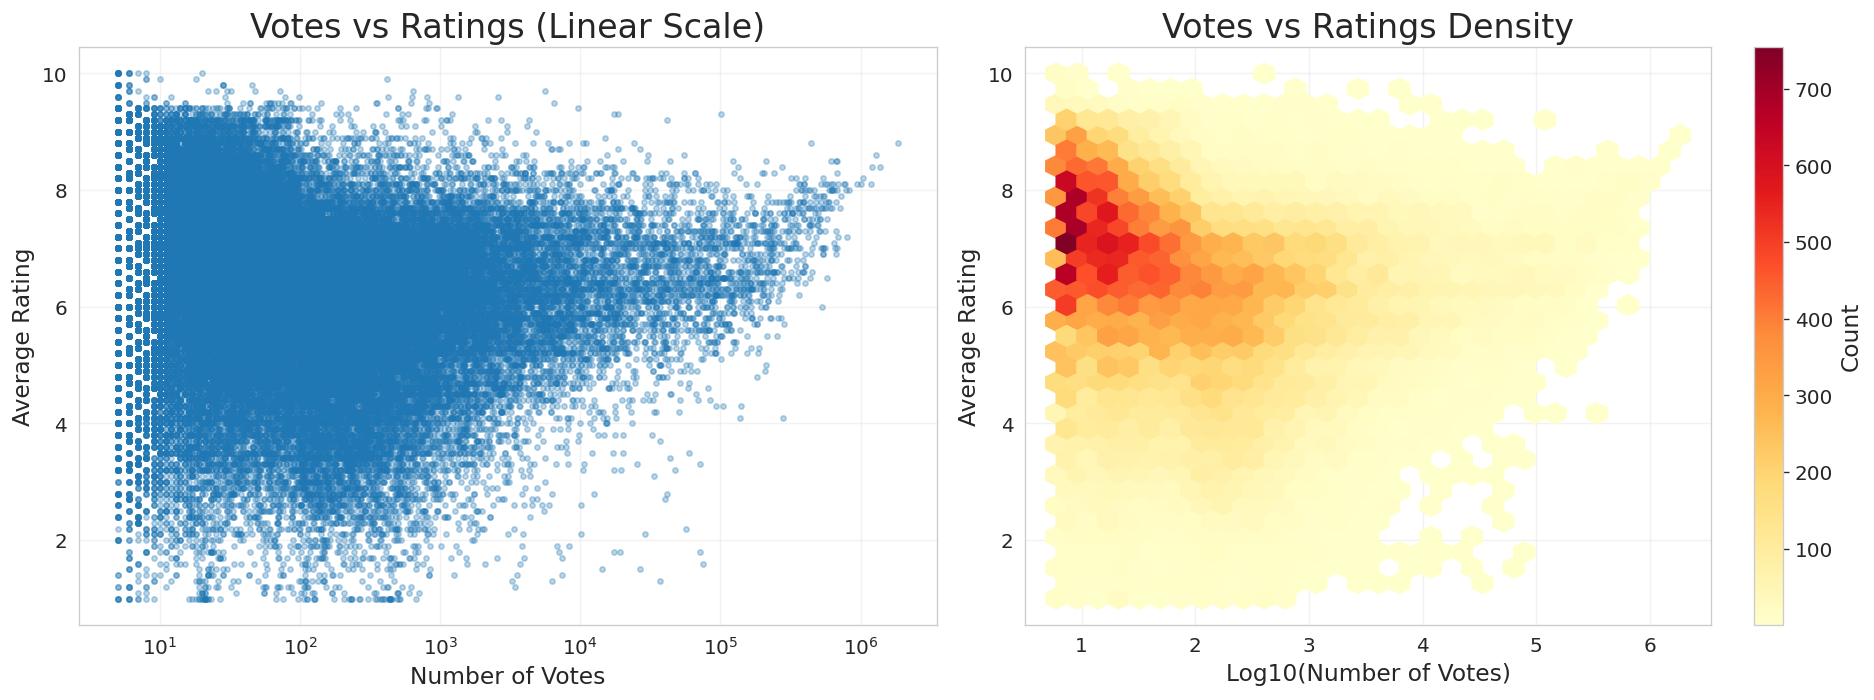


Pearson correlation: 0.044
Spearman correlation: -0.245


In [82]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
axes[0].scatter(df['num_votes'], df['average_ratings'], alpha=0.3, s=10)
axes[0].set_xlabel('Number of Votes')
axes[0].set_ylabel('Average Rating')
axes[0].set_title('Votes vs Ratings (Linear Scale)')
axes[0].set_xscale('log')

# Hexbin for density
hexbin = axes[1].hexbin(np.log10(df['num_votes'] + 1), df['average_ratings'], 
                         gridsize=30, cmap='YlOrRd', mincnt=1)
axes[1].set_xlabel('Log10(Number of Votes)')
axes[1].set_ylabel('Average Rating')
axes[1].set_title('Votes vs Ratings Density')
plt.colorbar(hexbin, ax=axes[1], label='Count')

plt.tight_layout()
plt.savefig(out_dir + "votes_vs_ratings.png")
plt.show()

# Correlation
correlation = df[['num_votes', 'average_ratings']].corr().iloc[0, 1]
print(f"\nPearson correlation: {correlation:.3f}")

# Spearman (better for non-linear relationships)
spearman_corr = stats.spearmanr(df['num_votes'].dropna(), df['average_ratings'].dropna())[0]
print(f"Spearman correlation: {spearman_corr:.3f}")

### The scatter plot suggests little to no linear relationship between the number of votes and average ratings. This is confirmed by the Pearson correlation (0.044), which indicates an almost negligible linear association.

### However, the Spearman correlation (-0.245) reveals a weak negative monotonic relationship. This suggests that, in general, movies with higher vote counts tend to have slightly lower ratings.

### In contrast, movies with fewer votes may represent niche audiences that rate content more favorably.

### Overall, popularity does not strongly predict higher ratings, and greater engagement may even be associated with slightly lower average scores.



## 3.5 Popularity vs Ratings Analysis
To further investigate the relationship between popularity and ratings, we segment movies into four popularity tiers based on vote count using quartiles.

This approach allows us to compare rating distributions across Low, Medium, High, and Very High popularity groups and determine whether audience reception differs systematically by engagement level.

Ratings by Popularity Tier:

/tmp/ipykernel_456645/82691730.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tier_stats = df.groupby('popularity_tier').agg({



                average_ratings              num_votes                     \
                           mean median   std       min      max      mean   
popularity_tier                                                             
Low                        6.83    7.0  1.48         5       14      8.65   
Medium                     6.53    6.7  1.47        15       49     27.66   
High                       5.94    6.1  1.45        50      282    127.78   
Very High                  6.03    6.2  1.30       283  1841066  13946.07   

                movie_id  
                   count  
popularity_tier           
Low                19172  
Medium             17860  
High               18379  
Very High          18445  


/tmp/ipykernel_456645/82691730.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tier_means = df.groupby('popularity_tier')['average_ratings'].mean()


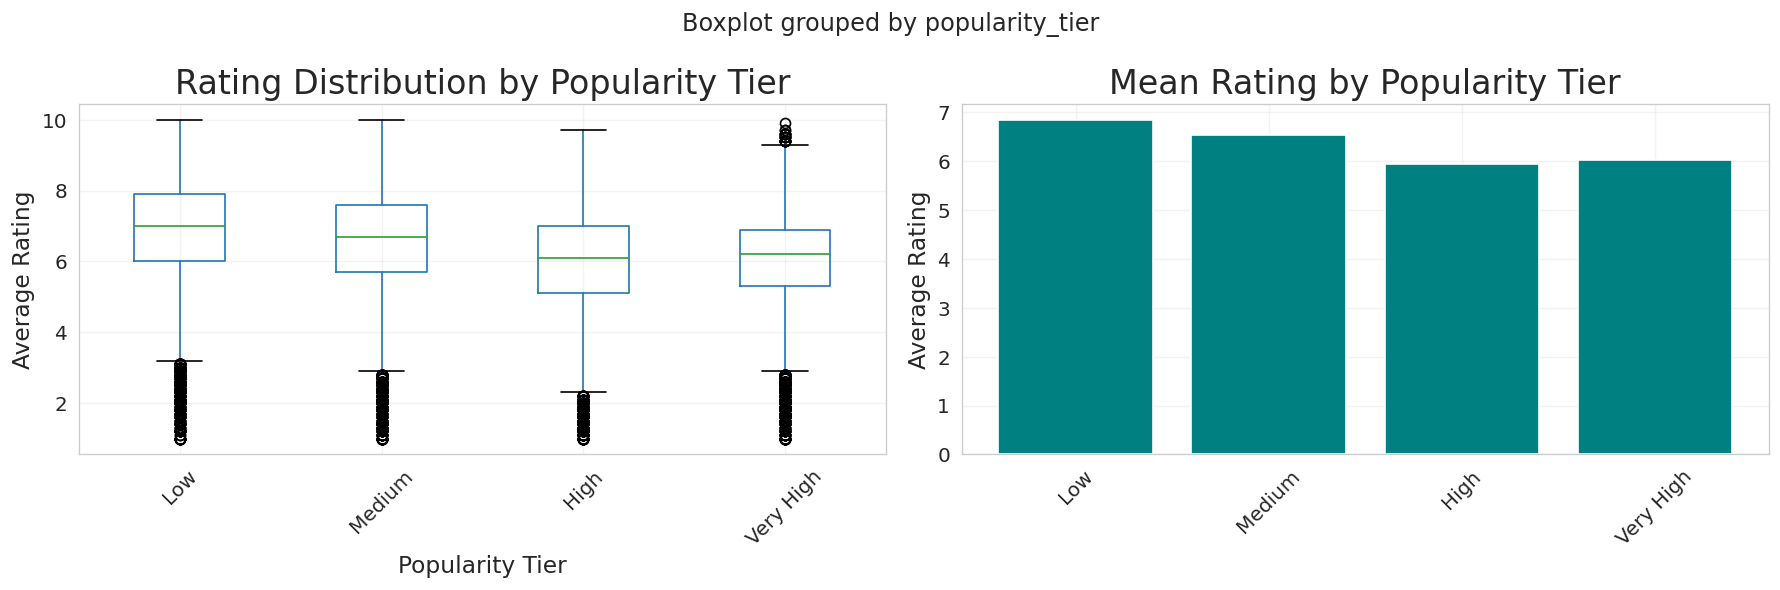

In [83]:
# Create popularity tiers
df['popularity_tier'] = pd.qcut(df['num_votes'], 
                                 q=4, 
                                 labels=['Low', 'Medium', 'High', 'Very High'])

# Compare ratings across tiers
tier_stats = df.groupby('popularity_tier').agg({
    'average_ratings': ['mean', 'median', 'std'],
    'num_votes': ['min', 'max', 'mean'],
    'movie_id': 'count'
}).round(2)

print("Ratings by Popularity Tier:")
print(tier_stats)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

df.boxplot(column='average_ratings', by='popularity_tier', ax=axes[0])
axes[0].set_xlabel('Popularity Tier')
axes[0].set_ylabel('Average Rating')
axes[0].set_title('Rating Distribution by Popularity Tier')
plt.sca(axes[0])
plt.xticks(rotation=45)

tier_means = df.groupby('popularity_tier')['average_ratings'].mean()
axes[1].bar(range(len(tier_means)), tier_means.values, color='teal')
axes[1].set_xticks(range(len(tier_means)))
axes[1].set_xticklabels(tier_means.index, rotation=45)
axes[1].set_ylabel('Average Rating')
axes[1].set_title('Mean Rating by Popularity Tier')

plt.tight_layout()
plt.savefig(out_dir + "pop_vs_ratings.png")
plt.show()

### The box plot and mean comparison reveal subtle differences in rating distributions across popularity tiers.

### Consistent with the earlier correlation analysis, higher popularity tiers do not show substantially higher ratings. In fact, the trend suggests that movies in the Very High popularity tier tend to have slightly lower average ratings compared to lower tiers.

### This supports the weak negative monotonic relationship observed earlier. Highly popular movies may attract broader audiences with more diverse opinions, resulting in slightly lower overall ratings. Meanwhile, less popular films may appeal to niche audiences who rate them more favorably.

### Overall, popularity alone does not appear to be a strong predictor of higher audience ratings.


## 3.6  Runtime vs ratings analysis
To understand the characteristics of movie lengths, we examine the distribution of runtimes in the dataset and explore how runtime relates to audience ratings. 

This analysis helps identify common runtime ranges and whether longer or shorter movies tend to receive higher ratings.

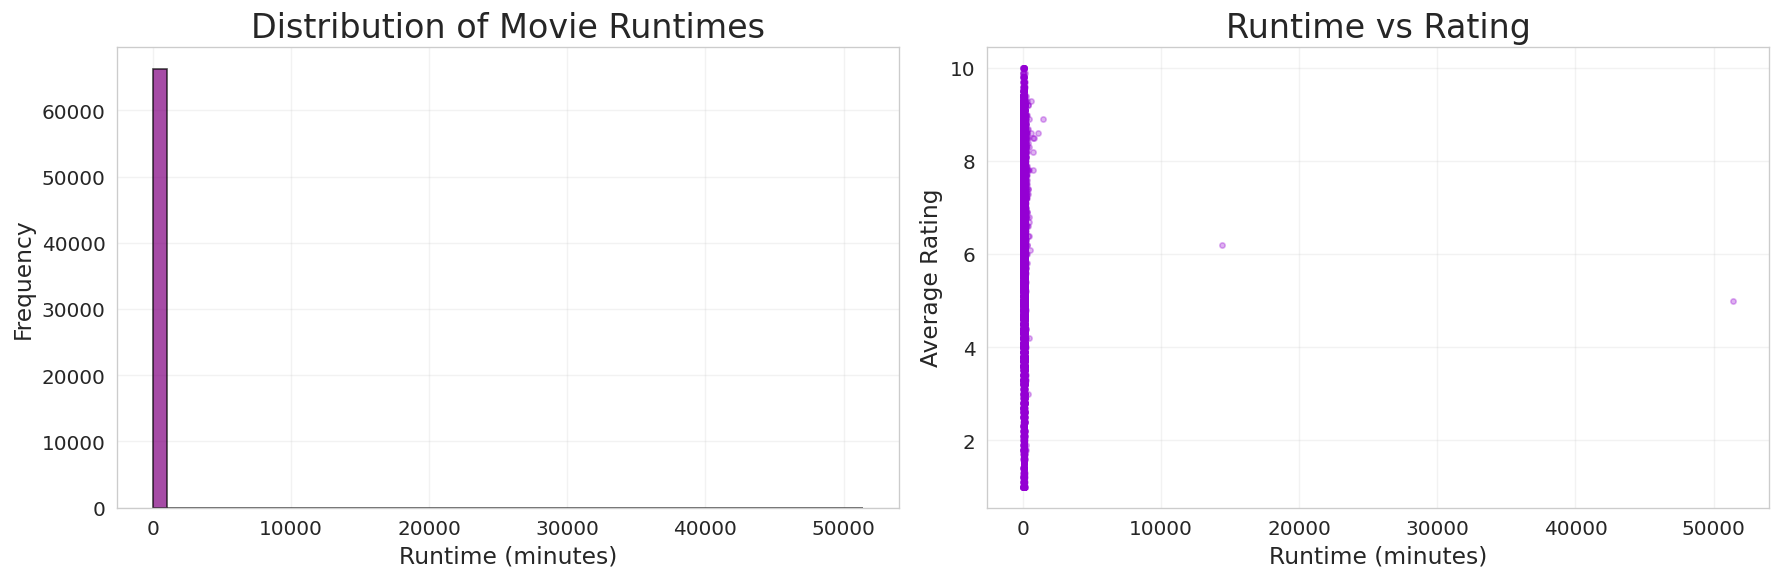

Runtime Statistics:
Mean: 95 minutes
Median: 91 minutes


In [84]:
# Runtime distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(df['runtime_minutes'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[0].set_xlabel('Runtime (minutes)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Movie Runtimes')

# Runtime vs Rating
axes[1].scatter(df['runtime_minutes'], df['average_ratings'], alpha=0.3, s=10, color='darkviolet')
axes[1].set_xlabel('Runtime (minutes)')
axes[1].set_ylabel('Average Rating')
axes[1].set_title('Runtime vs Rating')

plt.tight_layout()
plt.savefig(out_dir + "runtime_vs_ratings.png")
plt.show()

print(f"Runtime Statistics:")
print(f"Mean: {df['runtime_minutes'].mean():.0f} minutes")
print(f"Median: {df['runtime_minutes'].median():.0f} minutes")

### Overall, while runtime has a typical range, it does not appear to be a strong predictor of movie ratings.

## 3.7 Year-over-Year Trends
To understand how the film industry and audience reception have evolved, we analyze trends over time in three areas: 

1. Number of movies released per year  
2. Average audience ratings per year  
3. Average number of votes per year (as a proxy for engagement)

This helps identify periods of growth, shifts in audience preferences, and changes in engagement over time.

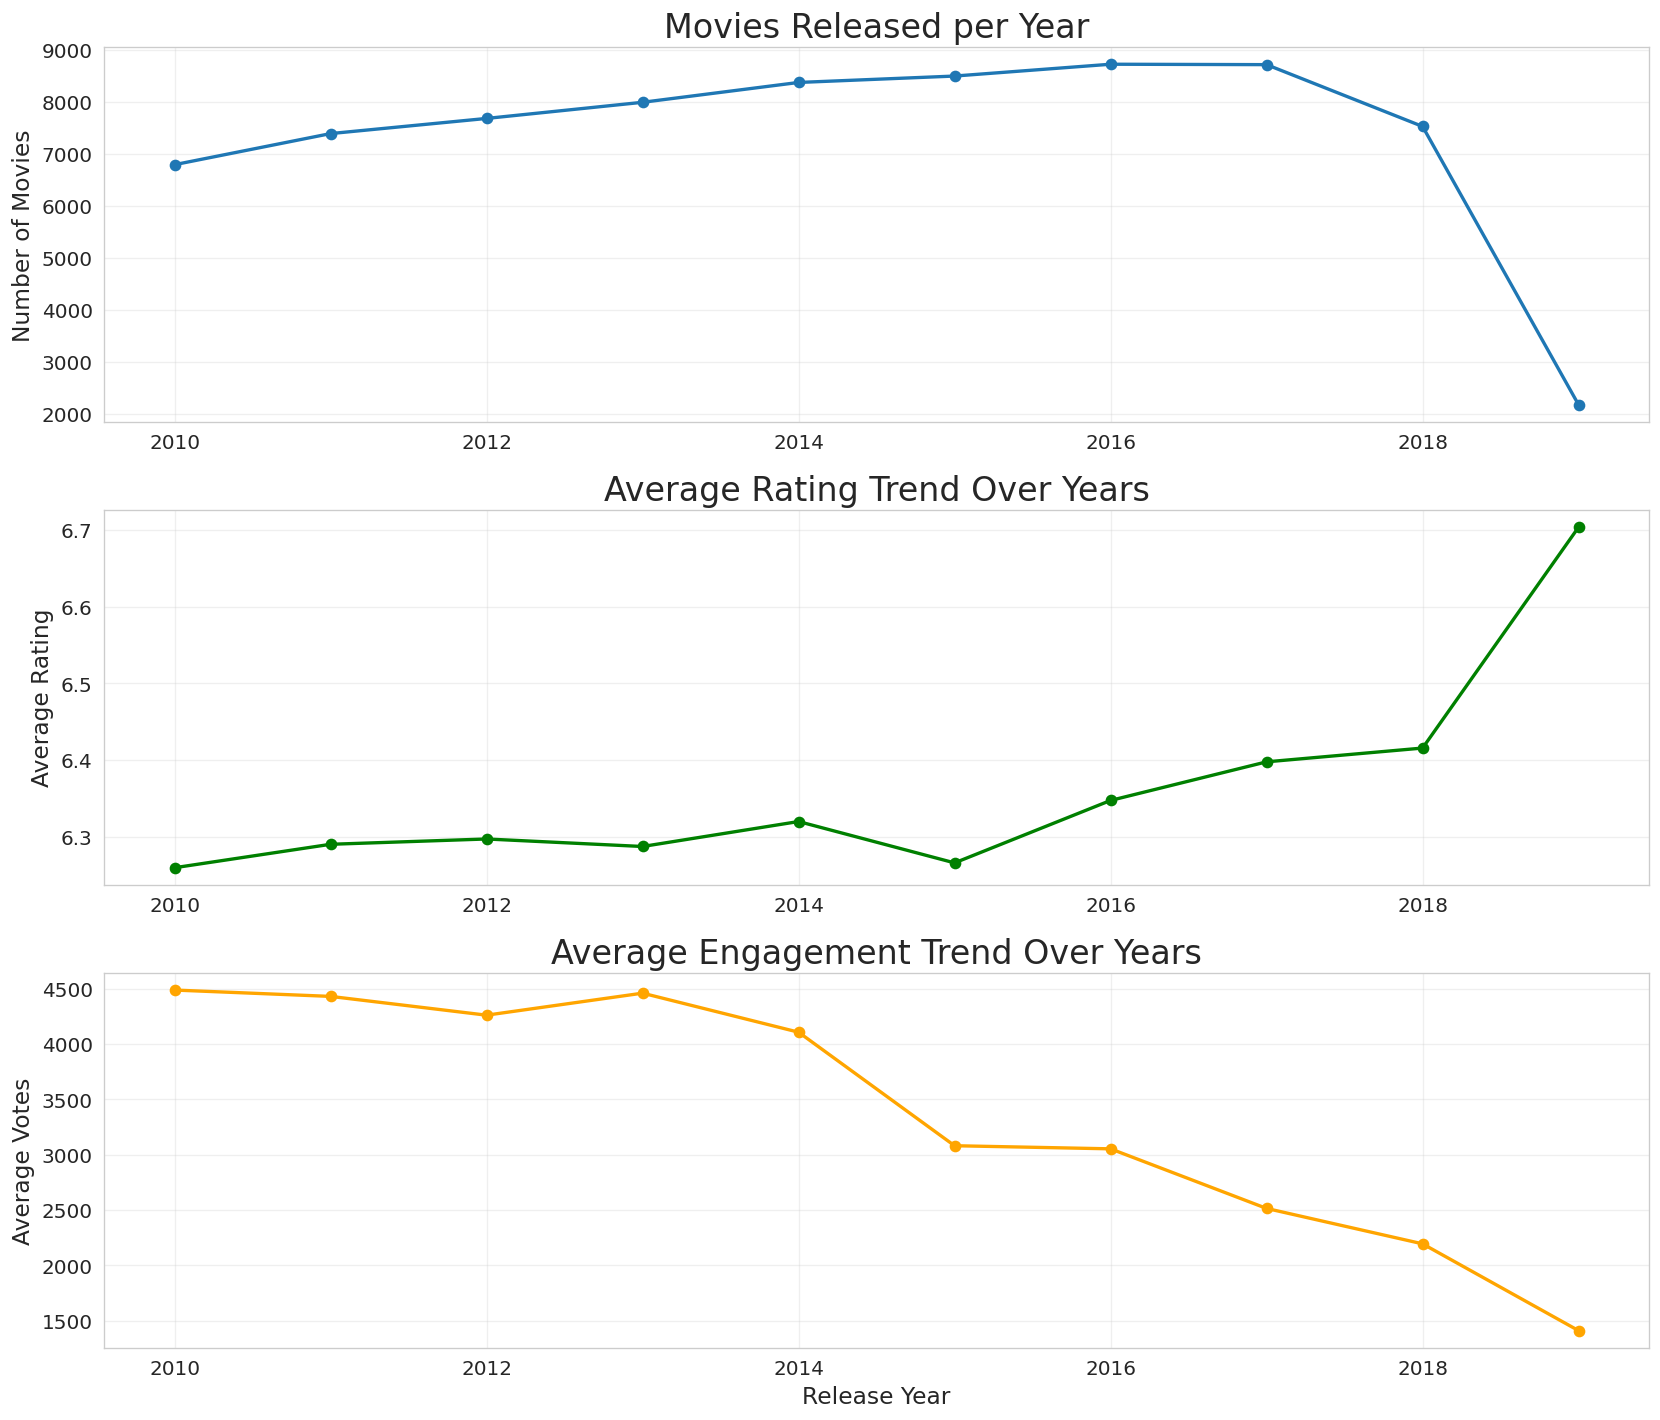

In [85]:
# Yearly trends
yearly_stats = df.groupby('release_year').agg({
    'average_ratings': 'mean',
    'num_votes': 'mean',
    'movie_id': 'count'
}).reset_index()

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Movies per year
axes[0].plot(yearly_stats['release_year'], yearly_stats['movie_id'], marker='o', linewidth=2)
axes[0].set_ylabel('Number of Movies')
axes[0].set_title('Movies Released per Year')
axes[0].grid(True, alpha=0.3)

# Average rating over time
axes[1].plot(yearly_stats['release_year'], yearly_stats['average_ratings'], 
             marker='o', linewidth=2, color='green')
axes[1].set_ylabel('Average Rating')
axes[1].set_title('Average Rating Trend Over Years')
axes[1].grid(True, alpha=0.3)

# Average votes over time
axes[2].plot(yearly_stats['release_year'], yearly_stats['num_votes'], 
             marker='o', linewidth=2, color='orange')
axes[2].set_xlabel('Release Year')
axes[2].set_ylabel('Average Votes')
axes[2].set_title('Average Engagement Trend Over Years')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(out_dir + "release_ratings_engagement_trends.png")
plt.show()

## Overall, while production and engagement have grown, average ratings have remained largely stable, indicating steady audience evaluation standards across decades.


## 3.8 Audience Insights & Key Findings


1. DATASET OVERVIEW
   - Total movies: 73,856
   - Year range: 2010 - 2019
   - Average rating: 6.33
   - Median votes: 49

2. RATING PATTERNS
   - Most common rating range: 7.0
   - Highly rated (>7.5): 15,125 movies (20.5%)
   - Poorly rated (<5.0): 12,383 movies (16.8%)

3. POPULARITY-QUALITY CONNECTION
   - Correlation (Spearman): -0.245
   - Finding: Popular movies tend to have LOWER ratings

4. HIDDEN GEMS (High rating, Low votes)
   - Count: 7,848 movies
   - Average rating: 8.17
   - Top 3 hidden gems:
     • Exteriores: Mulheres Brasileiras na Diplomacia - Rating: 10.0, Votes: 5
     • The Dark Knight: The Ballad of the N Word - Rating: 10.0, Votes: 5
     • Freeing Bernie Baran - Rating: 10.0, Votes: 5

5. BLOCKBUSTERS (High rating, High votes)
   - Count: 2,409 movies
   - Average rating: 7.83
   - Average votes: 37,467

6. TOP PERFORMING GENRES
   1. Documentary: 7.33 avg rating (17753 movies)
   2. News: 7.27 avg rating (579 movies)
   3. Biography: 7.16 avg rating (3809 movies)


# 4. Further comprehensive analysis

##  Merge our datasets

In [86]:
# ensure year in budgets
tn_budgets["year"] = pd.to_datetime(tn_budgets["release_date"], errors="coerce").dt.year

# create worldwide gross 
if "worldwide_gross" not in bom.columns:
    bom["domestic_gross"] = pd.to_numeric(bom["domestic_gross"], errors="coerce")
    bom["foreign_gross"] = pd.to_numeric(bom["foreign_gross"], errors="coerce")
    bom["worldwide_gross"] = bom["domestic_gross"] + bom["foreign_gross"]

# merge imdb basics + ratings
imdb = pd.merge(imdb_basics, imdb_ratings, on="movie_id", how="left")

# merge budgets with imdb (title + year)
merged = pd.merge(
    tn_budgets,
    imdb,
    left_on=["title_clean", "year"],
    right_on=["title_clean", "start_year"],
    how="left"
)

# merge bom gross
merged = pd.merge(
    merged,
    bom[["title_clean", "year", "domestic_gross", "foreign_gross", "worldwide_gross"]],
    on=["title_clean", "year"],
    how="left",
    suffixes=("_x", "_y")
)


# clean currency strings & convert to numeric
money_cols = [
    "production_budget",
    "domestic_gross_x", "worldwide_gross_x",   # from budgets (remove the $ sign)
    "domestic_gross_y", "foreign_gross", "worldwide_gross_y" 
]

for col in money_cols:
    if col in merged.columns:
        merged[col] = (
            merged[col]
            .astype(str)
            .str.replace(r"[\$,]", "", regex=True)
            .replace("nan", pd.NA)
        )
        merged[col] = pd.to_numeric(merged[col], errors="coerce")

# ratings numeric
if "averagerating" in merged.columns:
    merged["averagerating"] = pd.to_numeric(merged["averagerating"], errors="coerce")

merged.head()

,id,release_date,movie,production_budget,domestic_gross_x,worldwide_gross_x,title_clean,year,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,domestic_gross_y,foreign_gross,worldwide_gross_y
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,avatar,2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,pirates of the caribbean: on stranger tides,2011,tt1298650,Pirates of the Caribbean: On Stranger Tides,2011.0,136.0,"Action,Adventure,Fantasy",6.6,447624.0,241100000.0,804600000.0,1.045700e+09
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,dark phoenix,2019,tt6565702,Dark Phoenix,2019.0,113.0,"Action,Adventure,Sci-Fi",6.0,24451.0,NaN,NaN,NaN
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,avengers: age of ultron,2015,tt2395427,Avengers: Age of Ultron,2015.0,141.0,"Action,Adventure,Sci-Fi",7.3,665594.0,459000000.0,946400000.0,1.405400e+09
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,star wars ep. viii: the last jedi,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Check to see if well merged

In [87]:
merged[["movie", "production_budget", "worldwide_gross_y", "averagerating"]].head(10)



,movie,production_budget,worldwide_gross_y,averagerating
0,Avatar,425000000,NaN,NaN
1,Pirates of the Caribbean: On Stranger Tides,410600000,1.045700e+09,6.6
2,Dark Phoenix,350000000,NaN,6.0
3,Avengers: Age of Ultron,330600000,1.405400e+09,7.3
4,Star Wars Ep. VIII: The Last Jedi,317000000,NaN,NaN
5,Star Wars Ep. VII: The Force Awakens,306000000,NaN,NaN
6,Avengers: Infinity War,300000000,NaN,8.5
7,Pirates of the Caribbean: At Worldâs End,300000000,NaN,NaN
8,Justice League,300000000,6.579000e+08,6.5
9,Spectre,300000000,8.807000e+08,6.8


## Check to see how many values are present to be used in our analysis & chart generation

In [88]:
print("Total rows:", merged.shape[0])

print("\n% available (not NaN):")
print("production_budget:", merged["production_budget"].notna().mean())
print("worldwide_gross_y:", merged["worldwide_gross_y"].notna().mean())
print("domestic_gross_y:", merged["domestic_gross_y"].notna().mean())
print("averagerating:", merged["averagerating"].notna().mean())


Total rows: 5845

% available (not NaN):
production_budget: 1.0
worldwide_gross_y: 0.19059024807527802
domestic_gross_y: 0.21864841745081265
averagerating: 0.2636441402908469


## 4.2 Set global rules & sort data for more chart generation

In [89]:
# global syling rules & path for saving our images
plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "font.size": 12,
    "axes.titlesize": 20,
    "axes.labelsize": 14,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.spines.top": False,
    "axes.spines.right": False
})

def dollars_billions(x, pos):
    return f"${x/1e9:.1f}B"

def dollars_millions(x, pos):
    return f"${x/1e6:.0f}M"

# make sure columns have numeric valuess
for col in ["production_budget", "domestic_gross_y", "foreign_gross", "worldwide_gross_y", "averagerating"]:
    if col in merged.columns:
        merged[col] = pd.to_numeric(merged[col], errors="coerce")

# build genre-exploded dataframe
df = merged.copy()
df["genre_list"] = df["genres"].astype(str).str.split(",")
df = df.explode("genre_list")
df["genre_list"] = df["genre_list"].astype(str).str.strip()

# keep only rows with actual genre values
df = df[df["genre_list"].notna() & (df["genre_list"] != "") & (df["genre_list"] != "nan")]

# reduce noise in sample genre
MIN_MOVIES_PER_GENRE = 20
genre_counts = df["genre_list"].value_counts()
keep_genres = genre_counts[genre_counts >= MIN_MOVIES_PER_GENRE].index
df_g = df[df["genre_list"].isin(keep_genres)].copy()


## 4.3 Average ratings for each genre 

/tmp/ipykernel_456645/1351667370.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


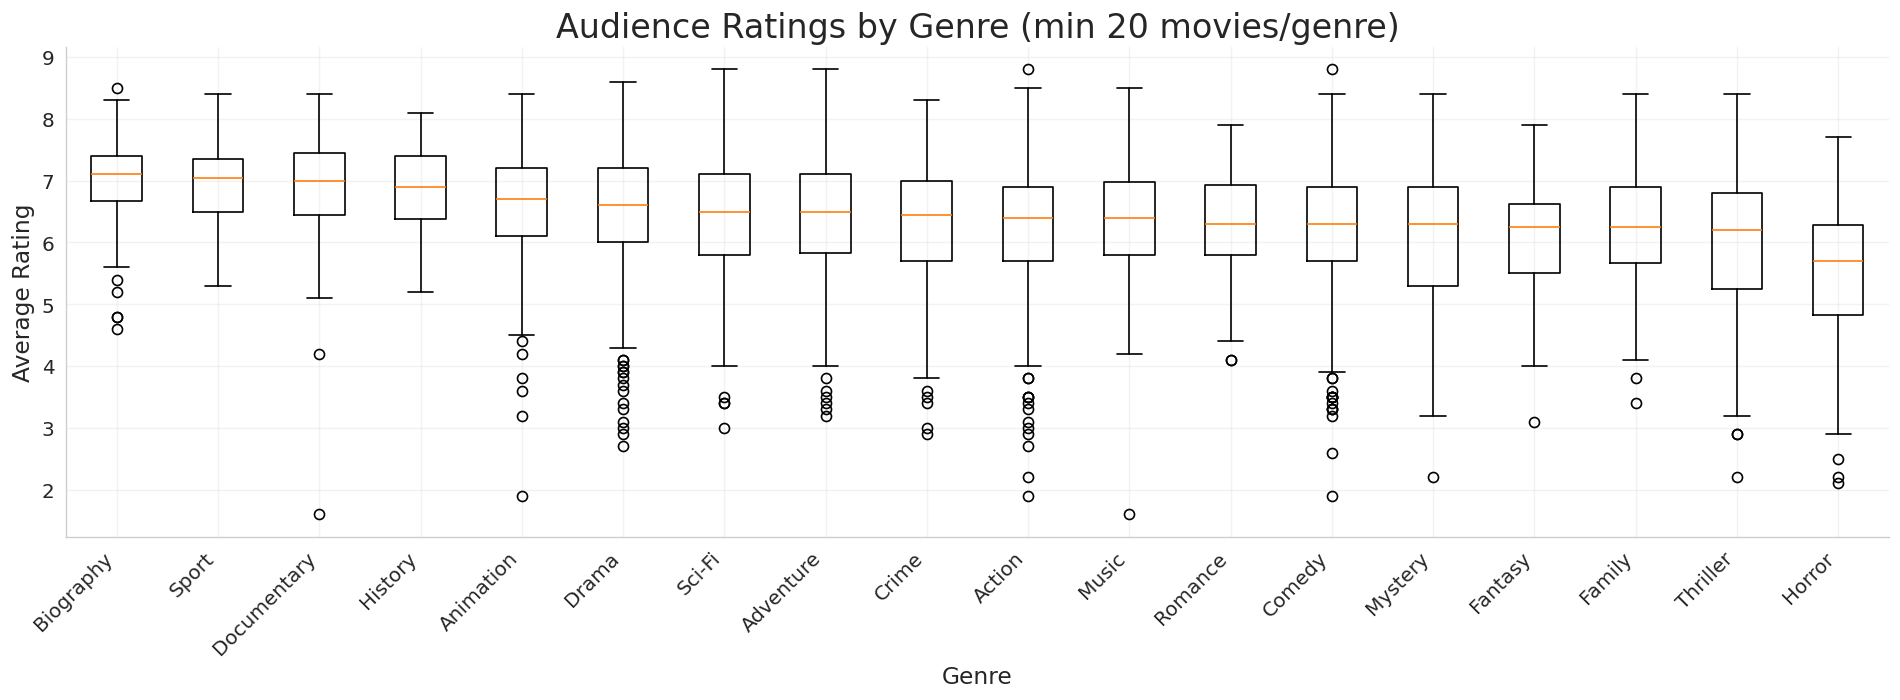

In [90]:
ratings_df = df_g.dropna(subset=["averagerating"]).copy()

# sort genres by median rating 
genre_median = ratings_df.groupby("genre_list")["averagerating"].median().sort_values(ascending=False)
genres_sorted = genre_median.index.tolist()

data_box = [ratings_df.loc[ratings_df["genre_list"] == g, "averagerating"].values for g in genres_sorted]

plt.figure(figsize=(16, 6))
plt.boxplot(
    data_box,
    labels=genres_sorted,
    showfliers=True
)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Genre")
plt.ylabel("Average Rating")
plt.title("Audience Ratings by Genre (min 20 movies/genre)")
plt.tight_layout()
plt.savefig(out_dir + "ratings_by_genre.png")
plt.show()


## 4.4 Worldwide Gross vs IMdb ratings

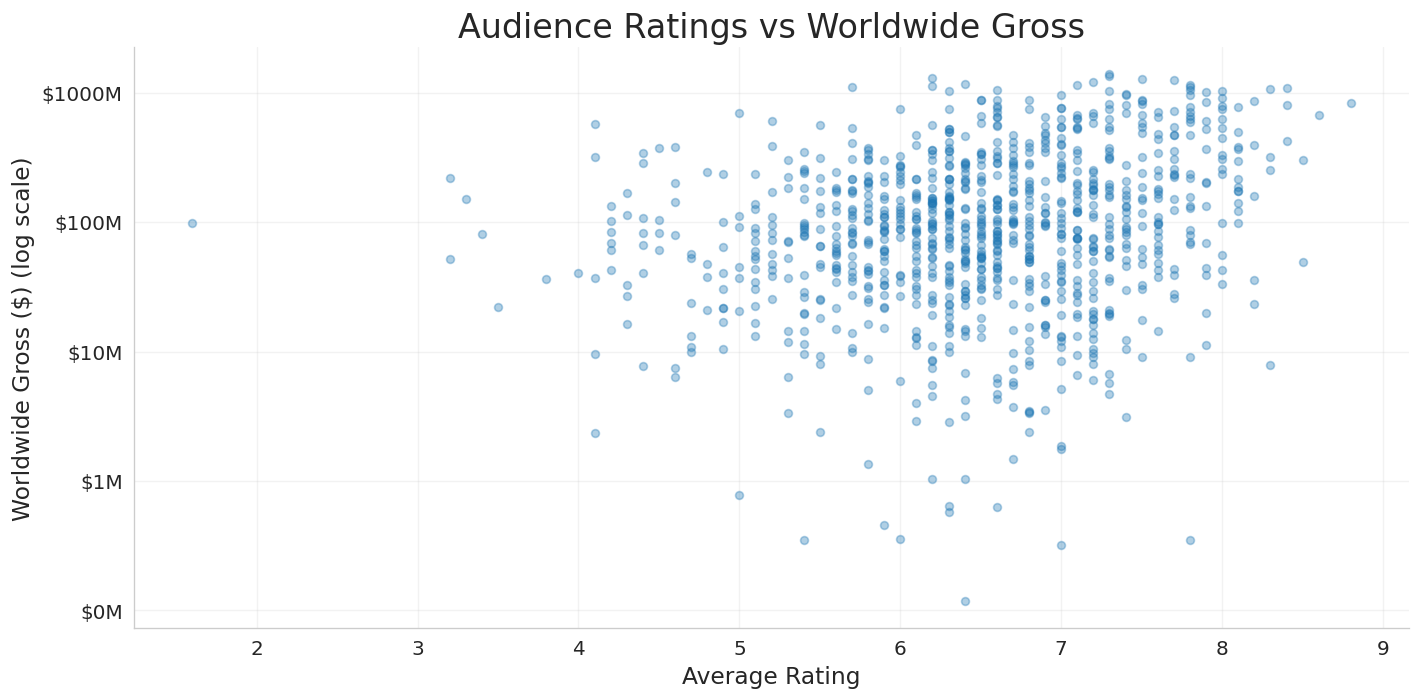

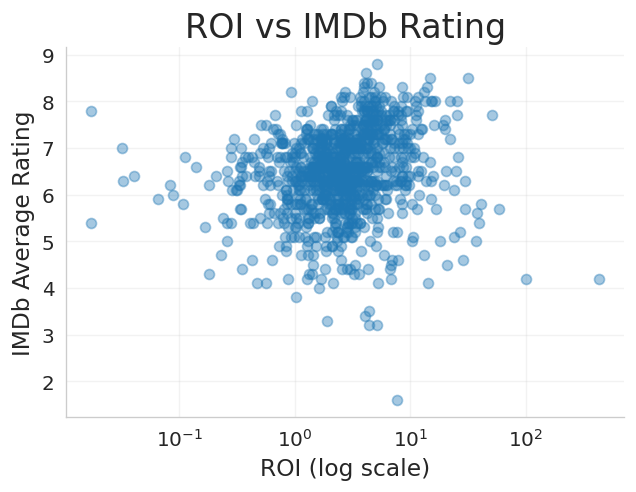

In [91]:
sc_df = merged.dropna(subset=["averagerating", "worldwide_gross_y"]).copy()
sc_df = sc_df[(sc_df["averagerating"] > 0) & (sc_df["worldwide_gross_y"] > 0)]

plt.figure(figsize=(12, 6))
plt.scatter(sc_df["averagerating"], sc_df["worldwide_gross_y"], alpha=0.35, s=22)
plt.yscale("log")
plt.xlabel("Average Rating")
plt.ylabel("Worldwide Gross ($) (log scale)")
plt.title("Audience Ratings vs Worldwide Gross")
plt.gca().yaxis.set_major_formatter(FuncFormatter(dollars_millions))
plt.tight_layout()
plt.savefig(out_dir + "ratings_vs_worldwide_gross.png")
plt.show()

df3 = merged.dropna(subset=["production_budget", "worldwide_gross_y", "averagerating"]).copy()
df3 = df3[(df3["production_budget"] > 0) & (df3["worldwide_gross_y"] > 0)]

df3["roi"] = df3["worldwide_gross_y"] / df3["production_budget"]

plt.figure(figsize=(6,4))
plt.scatter(df3["roi"], df3["averagerating"], alpha=0.4)
plt.xscale("log")
plt.xlabel("ROI (log scale)")
plt.ylabel("IMDb Average Rating")
plt.title("ROI vs IMDb Rating")
plt.grid(True)
plt.savefig(out_dir + "roi_vs_ratings_scatter.png")
plt.show()

### In the scatter plot above, the distibution of plots suggest that there is an average rating that has to be achieved (which reflects the quality of the film) in order to engage audiences, which drives up revenue ultimately deciding the ROI to be collected.

## 4.4 Budget vs Worldwide gross

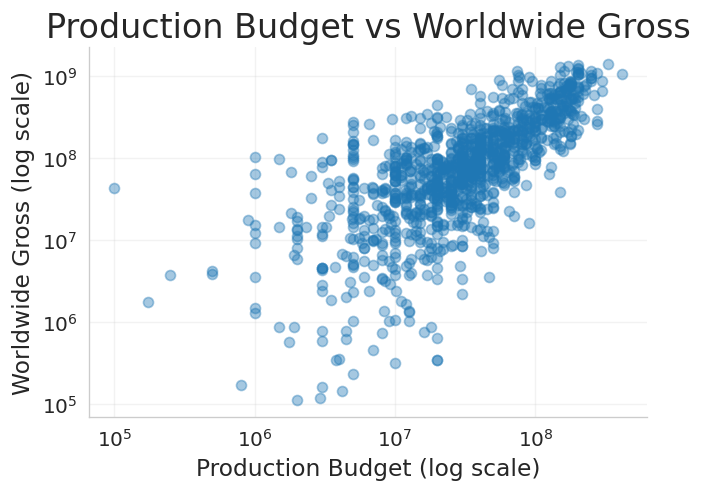

In [92]:
df2 = merged.dropna(subset=["production_budget", "worldwide_gross_y"])
df2 = df2[(df2["production_budget"] > 0) & (df2["worldwide_gross_y"] > 0)]

plt.figure(figsize=(6,4))
plt.scatter(df2["production_budget"], df2["worldwide_gross_y"], alpha=0.4)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Production Budget (log scale)")
plt.ylabel("Worldwide Gross (log scale)")
plt.title("Production Budget vs Worldwide Gross")
plt.grid(True)
plt.savefig(out_dir + "prod_budget_vs_ww_gross.png")
plt.show()


### The figure above indicates to us that films which had larger production budgets collect more revenue. This can be attributed to the fact that a bigger budget allows for the production of quality films and quality films draw the attention of larger audiences. The quality of film is an accumilation of multiple factors, the main factors being the cast, equipment quality, and the scenes in the script which are ultimately determined by the production budget available.   

## 4.5 Plot the average ROI for each genre

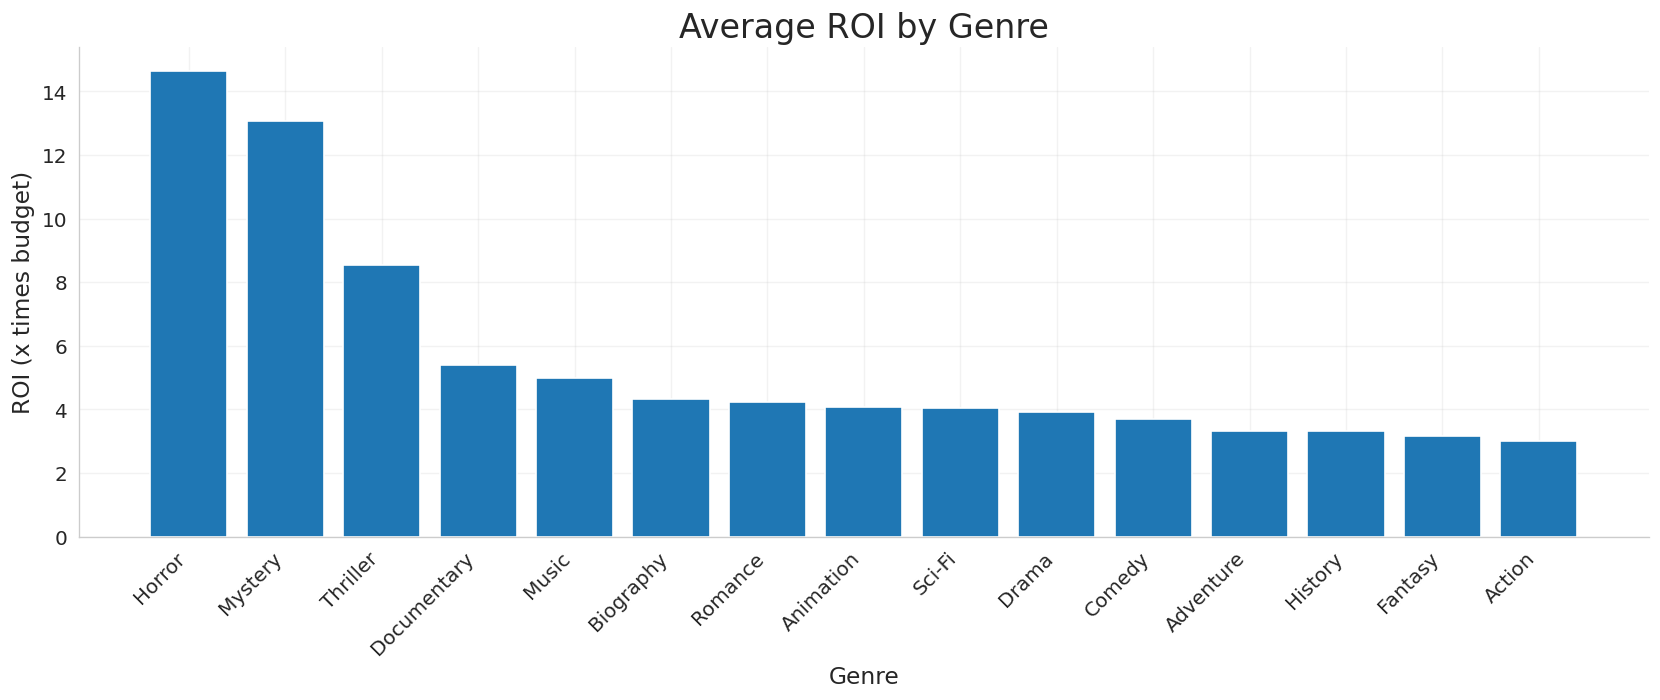

In [93]:
roi_df = df_g.dropna(subset=["production_budget", "worldwide_gross_y"]).copy()
roi_df = roi_df[(roi_df["production_budget"] > 0) & (roi_df["worldwide_gross_y"] > 0)]

roi_df["roi"] = roi_df["worldwide_gross_y"] / roi_df["production_budget"]

roi_by_genre = roi_df.groupby("genre_list")["roi"].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(14, 6))
plt.bar(roi_by_genre.index, roi_by_genre.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Genre")
plt.ylabel("ROI (x times budget)")
plt.title("Average ROI by Genre")
plt.tight_layout()
plt.savefig(out_dir + "avg_roi_by_genre.png")
plt.show()

### From the data in this figure we see the average ROI of each genre and tells us the most which type of genres offer the most capital efficient films to produce with the top 5 being horror, mystery, thriller, documentary and music films.

## 4.6 Plot the revenue for each genre 

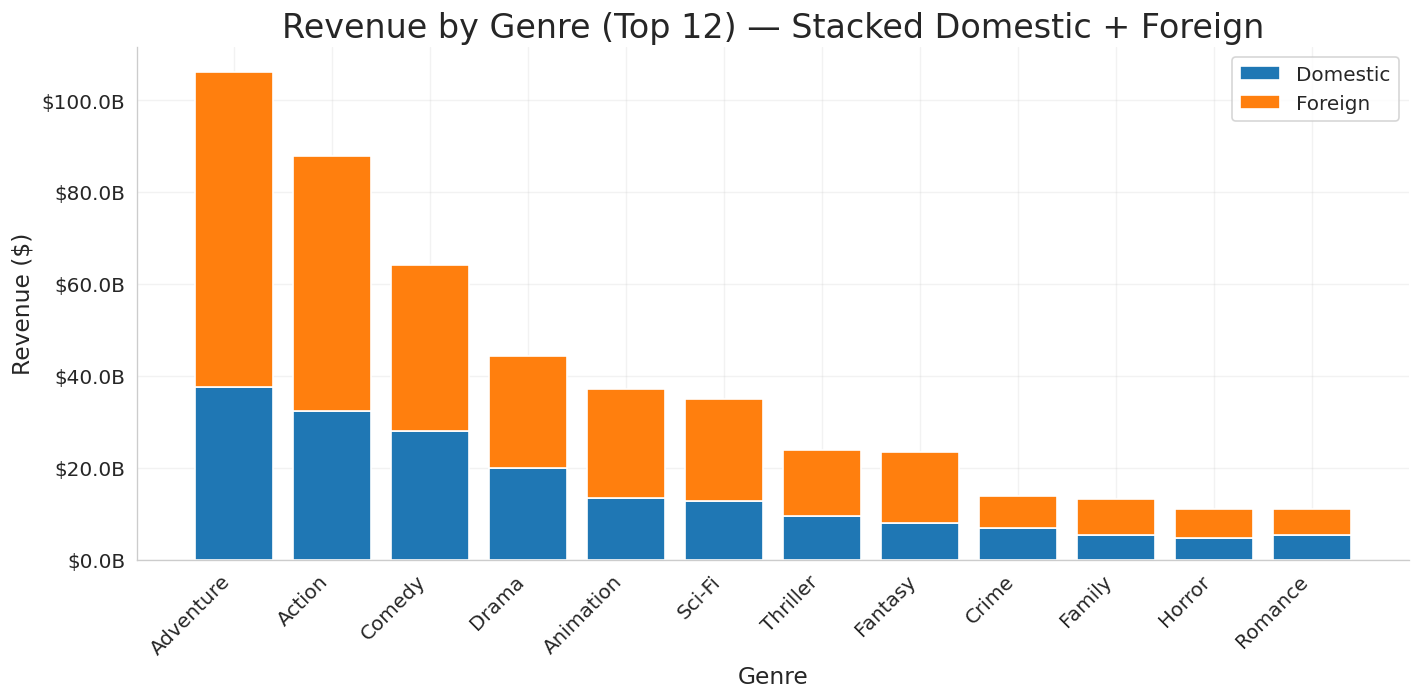

In [94]:
rev_df = df_g.dropna(subset=["domestic_gross_y", "foreign_gross", "worldwide_gross_y"]).copy()
rev_df = rev_df[(rev_df["domestic_gross_y"] >= 0) & (rev_df["foreign_gross"] >= 0) & (rev_df["worldwide_gross_y"] >= 0)]

genre_revenue = rev_df.groupby("genre_list").agg(
    domestic=("domestic_gross_y", "sum"),
    foreign=("foreign_gross", "sum"),
    worldwide=("worldwide_gross_y", "sum")
).sort_values("worldwide", ascending=False)

# take top 'N' genres for readability
TOP_N = 12
genre_revenue = genre_revenue.head(TOP_N)

x = np.arange(len(genre_revenue.index))
dom = genre_revenue["domestic"].values
forg = genre_revenue["foreign"].values  # stacked to reach worldwide

plt.figure(figsize=(12, 6))
plt.bar(x, dom, label="Domestic")
plt.bar(x, forg, bottom=dom, label="Foreign")

plt.xticks(x, genre_revenue.index, rotation=45, ha="right")
plt.xlabel("Genre")
plt.ylabel("Revenue ($)")
plt.title(f"Revenue by Genre (Top {TOP_N}) — Stacked Domestic + Foreign")
plt.gca().yaxis.set_major_formatter(FuncFormatter(dollars_billions))
plt.legend()
plt.tight_layout()
plt.savefig(out_dir + "revenue_by_genre.png")
plt.show()


### From the data in the figure above we learn that the top 5 genres are Adventure, Action, Comedy, Drama and Animation. These genres should be the top considerations for companies ventureing into the film production space. It is also notable that foreign revenure exeeds domestic revenure in almost every genre. This is a sign that script writers and produces should greatly consider. Having english as the main language in the script and also offering subtitles in multiple languages will gratly assist in reaching larger audiences.

## 4.7 Plot average world wide revenue for movies released in each month

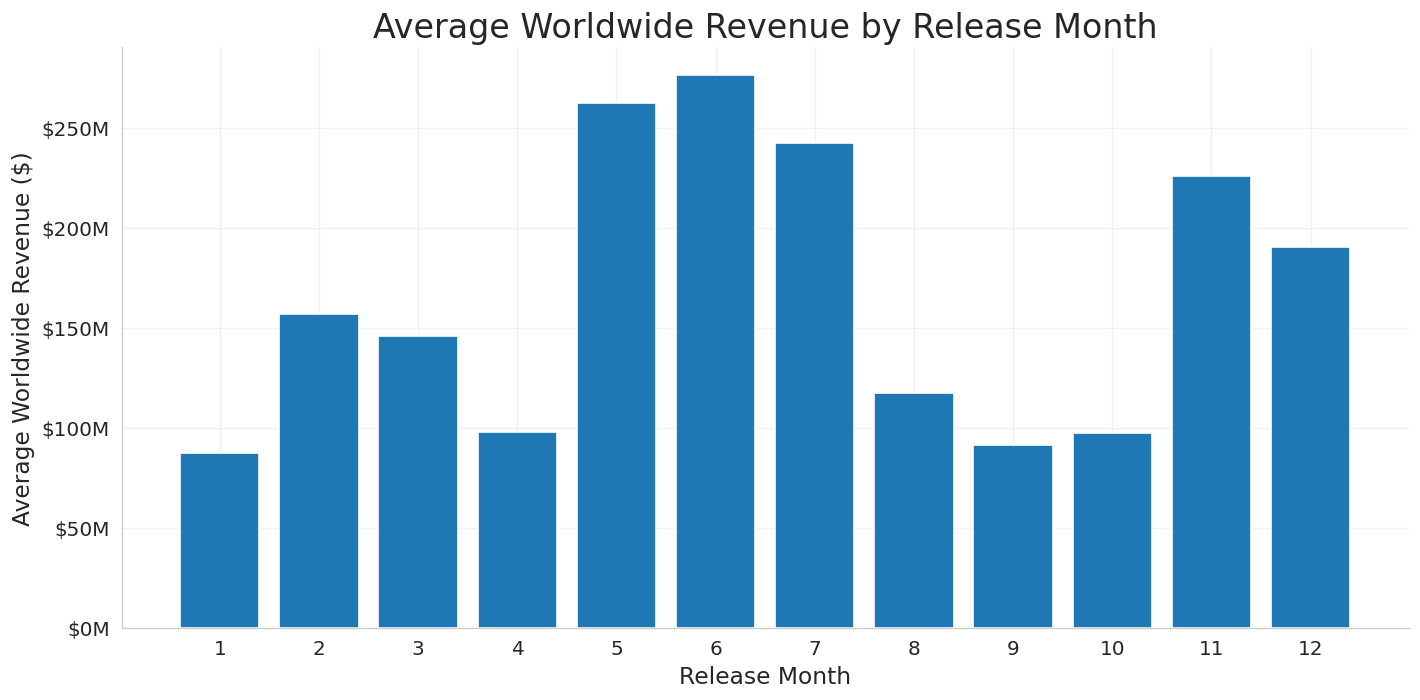

In [95]:
# pick gross columns
gross_pref = "worldwide_gross_y"
gross_fallback = "worldwide_gross_x" if "worldwide_gross_x" in merged.columns else None

# build base month data from release_date
month_base = merged[["release_date"]].copy()
month_base["release_dt"] = pd.to_datetime(month_base["release_date"], errors="coerce")
month_base = month_base.dropna(subset=["release_dt"])
month_base["release_month"] = month_base["release_dt"].dt.month

# try first gross first
month_df = month_base.join(merged[gross_pref].rename("gross"))
month_df["gross"] = pd.to_numeric(month_df["gross"], errors="coerce")
month_df = month_df.dropna(subset=["gross"])
month_df = month_df[month_df["gross"] > 0]

months_present = month_df["release_month"].nunique()
used_col = gross_pref

# if data missing, fall back to budgets dataset gross
if months_present <= 2 and gross_fallback is not None:
    month_df = month_base.join(merged[gross_fallback].rename("gross"))
    month_df["gross"] = pd.to_numeric(month_df["gross"], errors="coerce")
    month_df = month_df.dropna(subset=["gross"])
    month_df = month_df[month_df["gross"] > 0]
    used_col = gross_fallback

# compute monthly averages show all months & fill missing with 0
month_avg = (
    month_df.groupby("release_month")["gross"]
    .mean()
    .reindex(range(1, 13), fill_value=0)
)

plt.figure(figsize=(12, 6))
plt.bar(month_avg.index, month_avg.values)
plt.xlabel("Release Month")
plt.ylabel("Average Worldwide Revenue ($)")
plt.title(f"Average Worldwide Revenue by Release Month")
plt.gca().yaxis.set_major_formatter(FuncFormatter(dollars_millions))
plt.xticks(range(1, 13))
plt.tight_layout()
plt.savefig(out_dir + "avg_worldwide_revenue_by_month.png")
plt.show()

### The graph shows the average revenue generated by films released from January to December. From this we note that films released around spring-summer holidays(May,June,July) and toward the christmas season(Nov,Dec) perform better than films released any other months. This is because of a number of reasons the main ones being larger populations of people are taking breaks from their work or studies and have more time to engage in recreational activities. 

## Conclusions & Key Findings

### 1. High ratings ≠ high revenue. Audience ratings and worldwide gross show only a weak relationship. This simply great reviews don’t guarantee box office success. This is because commercial performance is driven more by distribution, marketing, franchise power, and release timing other than by ratings alone.

### 2. Certain genres consistently outperform financially. A small set of genres delivers the strongest returns on investment. These genres combine scalable audiences with predictable demand, making them lo

### 3. Release timing materially affects revenue. Average worldwide revenue varies significantly by release month. Peak months which are usually major holidays and summer windows outperform off-peak months greatly. This confirms that when a film is released can be as important as what film is released.

### 4. International markets drive the majority of revenue. Foreign gross often exceeds domestic gross for top-performing genres and titles. This indicates that global appeal and international distribution strategy are critical to maximizing returns. Also global reach may mean having the film scripted in english or atleast offer english subtitles.

### 5. ROI highlights capital efficiency, not just raw revenue. Big-budget blockbusters dominate absolute revenue, but ROI analysis shows that mid-budget films in the right genres can outperform in capital efficiency. 
